# Exploration of factors influencing students’ PISA scores in Singapore with Machine Learning approaches: Regression Models

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns 
from scipy import stats

from sklearn.linear_model import LinearRegression 
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, LassoCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_val_score


import xgboost as xgb
from xgboost.sklearn import XGBRegressor

import xgboost as xg 
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn.linear_model import LinearRegression
# Feature Importance 
import shap
from sklearn.inspection import PartialDependenceDisplay

In [2]:
#Import main data file
pisa2018_singapore = pd.read_csv('datasets/pisa2018_singapore.csv')

In [3]:
pisa2018_singapore.head()

CNTRYID    CNTSCHID    CNTSTUID                             STRATUM  \
0  Singapore  70200001.0  70200318.0  SGP - stratum 01: Public,Secondary   
1  Singapore  70200001.0  70200654.0  SGP - stratum 01: Public,Secondary   
2  Singapore  70200001.0  70200660.0  SGP - stratum 01: Public,Secondary   
3  Singapore  70200001.0  70200994.0  SGP - stratum 01: Public,Secondary   
4  Singapore  70200001.0  70201373.0  SGP - stratum 01: Public,Secondary   

   EFFORT1  EFFORT2                                     OCOD1  \
0     10.0     10.0                    Teaching professionals   
1      NaN      NaN                     Personal care workers   
2      8.0      9.0  Legal, social and cultural professionals   
3      7.0      3.0                            Not applicable   
4      9.0     10.0    Administrative and commercial managers   

                                               OCOD2  \
0          Business and administration professionals   
1                             Teaching professionals   
2  Chief executives, senior officials and legisla...   
3                 Drivers and mobile plant operators   
4       Production and specialised services managers   

                                               OCOD3  GRADE  ...  \
0                   Graphic and multimedia designers    0.0  ...   
1                          Early childhood educators    0.0  ...   
2  Engineering professionals not elsewhere classi...    0.0  ...   
3  Vague(a good job, a quiet job, a well paid job...   -1.0  ...   
4                                      Travel guides    0.0  ...   

                    UNIT WVARSTRR    SENWT             VER_DAT test GENDER  \
0  final variance unit 1     41.0  0.28939    14AUG19:14:08:12  NaN      0   
1  final variance unit 1     61.0  0.30028    14AUG19:14:08:12  NaN      1   
2  final variance unit 1     11.0  0.28939    14AUG19:14:08:12  NaN      0   
3  final variance unit 2     54.0  0.33367    14AUG19:14:08:12  NaN      0   
4  final variance unit 1     30.0  0.30028    14AUG19:14:08:12  NaN      1   

       MATH   SCIENCE      READ  TOTALSCORE  
0  706.3670  696.1431  772.8338  725.114633  
1  432.0569  418.7334  456.1390  435.643100  
2  600.0765  603.6294  533.6724  579.126100  
3  422.5786  425.4020  403.0926  417.024400  
4  596.1870  603.2735  616.6650  605.375167  

[5 rows x 129 columns]

In [4]:
#Check simple statistics
pisa2018_singapore.describe().round(2).T

count         mean      std          min          25%  \
CNTSCHID    6676.0  70200083.74    47.42  70200001.00  70200043.00   
CNTSTUID    6676.0  70203582.21  2071.02  70200001.00  70201782.75   
EFFORT1     5628.0         7.54     1.89         1.00         7.00   
EFFORT2     5597.0         9.24     1.39         1.00         9.00   
GRADE       6676.0        -0.09     0.34        -3.00         0.00   
...            ...          ...      ...          ...          ...   
GENDER      6676.0         0.49     0.50         0.00         0.00   
MATH        6676.0       568.29    88.37       249.16       510.61   
SCIENCE     6676.0       549.97    93.81       196.01       486.96   
READ        6676.0       548.46   106.93       169.94       478.81   
TOTALSCORE  6676.0       555.57    93.33       232.33       494.16   

                    50%          75%          max  
CNTSCHID    70200085.00  70200124.00  70200166.00  
CNTSTUID    70203583.50  70205372.25  70207170.00  
EFFORT1            8.00         9.00        10.00  
EFFORT2           10.00        10.00        10.00  
GRADE              0.00         0.00         1.00  
...                 ...          ...          ...  
GENDER             0.00         1.00         1.00  
MATH             578.57       633.20       777.50  
SCIENCE          560.93       619.60       805.27  
READ             559.62       627.93       823.40  
TOTALSCORE       566.42       625.18       784.57  

[100 rows x 8 columns]

In [5]:
pisa2018_singapore.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6676 entries, 0 to 6675
Columns: 129 entries, CNTRYID to TOTALSCORE
dtypes: float64(99), int64(1), object(29)
memory usage: 6.6+ MB


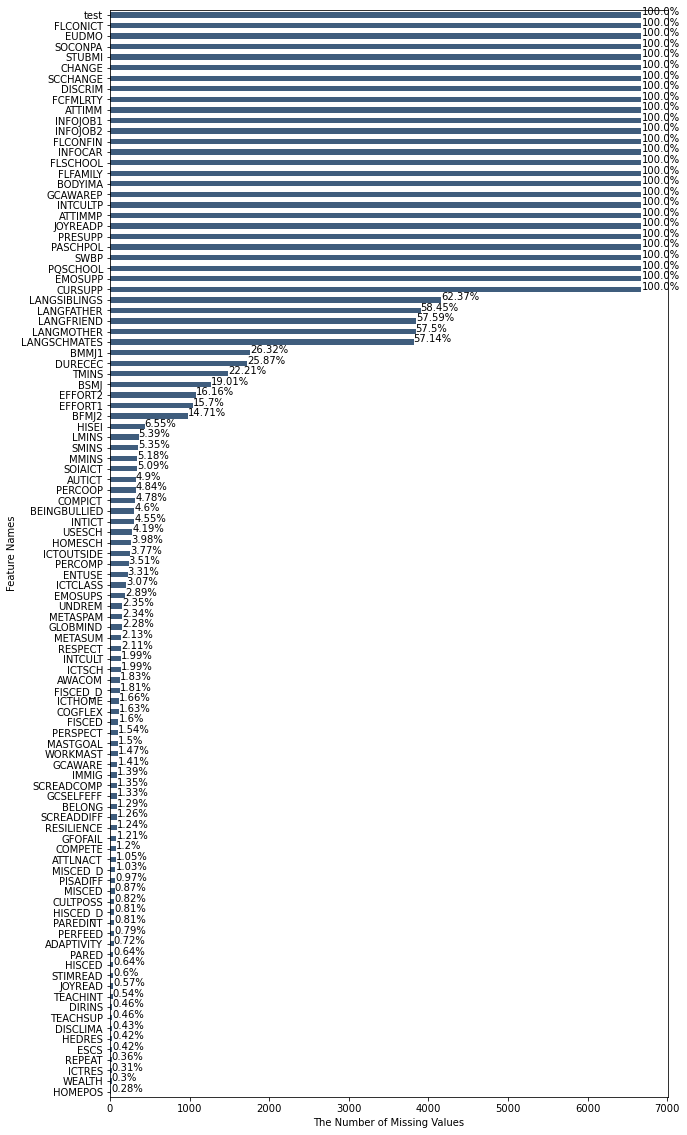

In [6]:
#Checking percentage of null values

Nan = pisa2018_singapore.isnull().sum()[pisa2018_singapore.isnull().sum()>0]

Nan.sort_values().plot(kind='barh', figsize=(10, 20), color = "#3F5D7D");

for y, x in enumerate(Nan.sort_values()):
    
    plt.annotate(str(round(x/pisa2018_singapore.shape[0]*100,2))+'%', xy=(x, y), size=10)
    
plt.xlabel('The Number of Missing Values')

plt.ylabel('Feature Names');

In [7]:
#Drop column with NAN more than 10%
NanPer = len(pisa2018_singapore) *.90
pisa2018_singapore = pisa2018_singapore.dropna(thresh=NanPer, axis=1)

In [8]:
#Split data into train and test
train_singapore , test_singapore  = train_test_split(pisa2018_singapore, test_size=0.2, random_state=42)

print(f"No. of training examples: {train_singapore.shape[0]}")
print(f"No. of testing examples: {test_singapore.shape[0]}")

No. of training examples: 5340
No. of testing examples: 1336


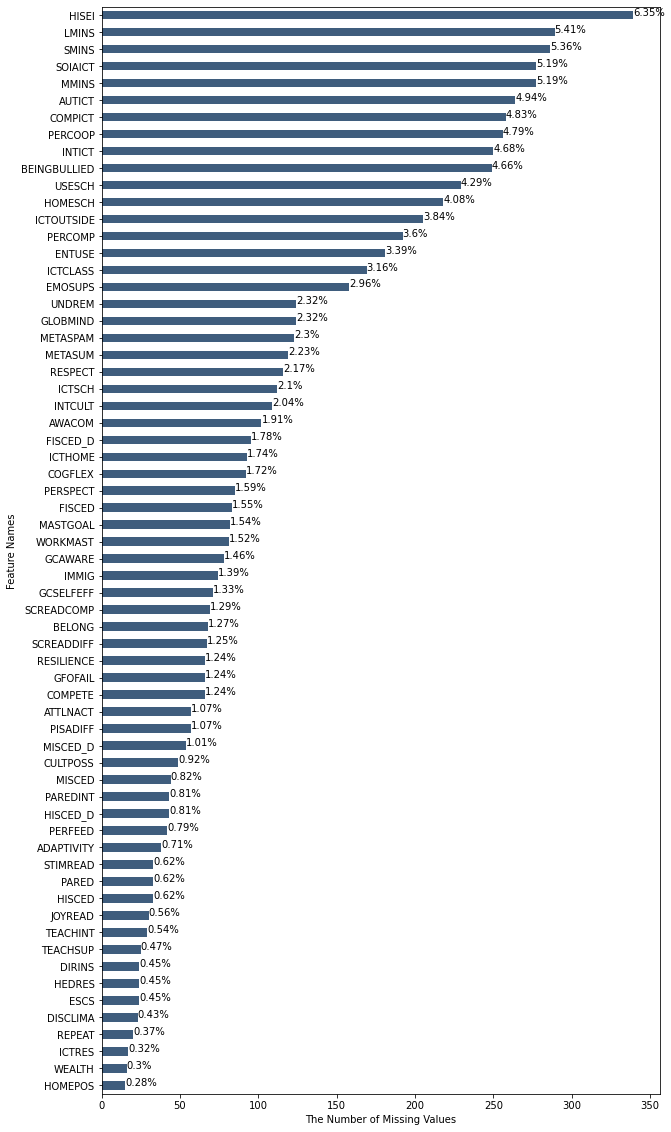

In [9]:
#Checking percentage of null values

Nan = train_singapore.isnull().sum()[train_singapore.isnull().sum()>0]

Nan.sort_values().plot(kind='barh', figsize=(10, 20), color = "#3F5D7D");

for y, x in enumerate(Nan.sort_values()):
    
    plt.annotate(str(round(x/train_singapore.shape[0]*100,2))+'%', xy=(x, y), size=10)
    
plt.xlabel('The Number of Missing Values')

plt.ylabel('Feature Names');

In [10]:
#change data type
train_singapore['GENDER'] = train_singapore['GENDER'].astype('object')
test_singapore['GENDER'] = test_singapore['GENDER'].astype('object')

In [11]:
#Fill NAN values with train columns' median
numvar = train_singapore.dtypes !="object"
numeric_features = list(numvar[numvar].index)
for col in numeric_features:
    train_singapore[col].fillna(train_singapore[col].median(), inplace=True)
    test_singapore[col].fillna(train_singapore[col].median(), inplace=True)

In [12]:
#Fill NAN values with train columns' mode
obvar = train_singapore.dtypes =="object"
categorical_features = list(obvar[obvar].index)
for col in categorical_features:
    train_singapore[col].fillna(train_singapore[col].mode()[0], inplace=True)
    test_singapore[col].fillna(train_singapore[col].mode()[0], inplace=True)

In [13]:
train_singapore.isnull().sum().sum(),test_singapore.isnull().sum().sum()

(0, 0)

In [14]:
list(train_singapore.columns)

['CNTRYID',
 'CNTSCHID',
 'CNTSTUID',
 'STRATUM',
 'OCOD1',
 'OCOD2',
 'OCOD3',
 'GRADE',
 'AGE',
 'PROGN',
 'COBN_S',
 'COBN_M',
 'COBN_F',
 'LANGN',
 'ISCEDL',
 'ISCEDD',
 'ISCEDO',
 'MISCED',
 'FISCED',
 'HISCED',
 'PARED',
 'MISCED_D',
 'FISCED_D',
 'HISCED_D',
 'PAREDINT',
 'HISEI',
 'IMMIG',
 'REPEAT',
 'MMINS',
 'LMINS',
 'SMINS',
 'ESCS',
 'UNDREM',
 'METASUM',
 'METASPAM',
 'ICTHOME',
 'ICTSCH',
 'HOMEPOS',
 'CULTPOSS',
 'HEDRES',
 'WEALTH',
 'ICTRES',
 'DISCLIMA',
 'TEACHSUP',
 'DIRINS',
 'PERFEED',
 'EMOSUPS',
 'STIMREAD',
 'ADAPTIVITY',
 'TEACHINT',
 'JOYREAD',
 'SCREADCOMP',
 'SCREADDIFF',
 'PISADIFF',
 'PERCOMP',
 'PERCOOP',
 'ATTLNACT',
 'COMPETE',
 'WORKMAST',
 'GFOFAIL',
 'RESILIENCE',
 'MASTGOAL',
 'GCSELFEFF',
 'GCAWARE',
 'INTCULT',
 'PERSPECT',
 'COGFLEX',
 'RESPECT',
 'AWACOM',
 'GLOBMIND',
 'BELONG',
 'BEINGBULLIED',
 'ENTUSE',
 'HOMESCH',
 'USESCH',
 'INTICT',
 'COMPICT',
 'AUTICT',
 'SOIAICT',
 'ICTCLASS',
 'ICTOUTSIDE',
 'UNIT',
 'WVARSTRR',
 'SENWT',
 'VER_DA

In [15]:
#Set CNTSTUID as index
train_singapore.set_index('CNTSTUID', inplace=True)
test_singapore.set_index('CNTSTUID', inplace=True)

In [16]:
train_singapore.drop(columns=['CNTRYID','CNTSCHID','STRATUM','OCOD1','OCOD2','OCOD3','PROGN','COBN_S',
                                'COBN_M','COBN_F','LANGN','UNIT', 'VER_DAT', 'SENWT'], axis =1, inplace = True)
test_singapore.drop(columns=['CNTRYID','CNTSCHID','STRATUM','OCOD1','OCOD2','OCOD3','PROGN','COBN_S',
                                'COBN_M','COBN_F','LANGN','UNIT', 'VER_DAT', 'SENWT'], axis =1, inplace = True)

In [17]:
train_singapore.shape, test_singapore.shape

((5340, 75), (1336, 75))

## Exploring numerical variables

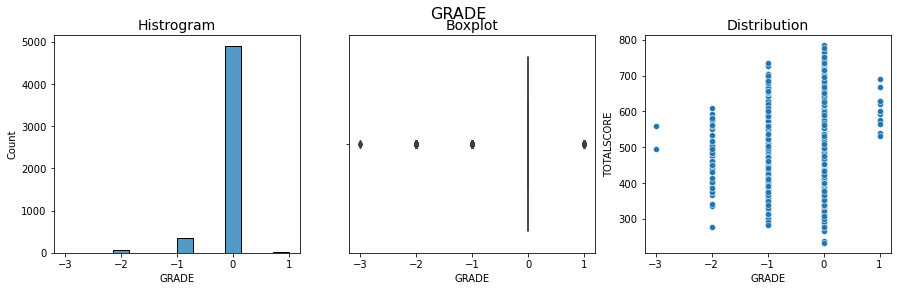

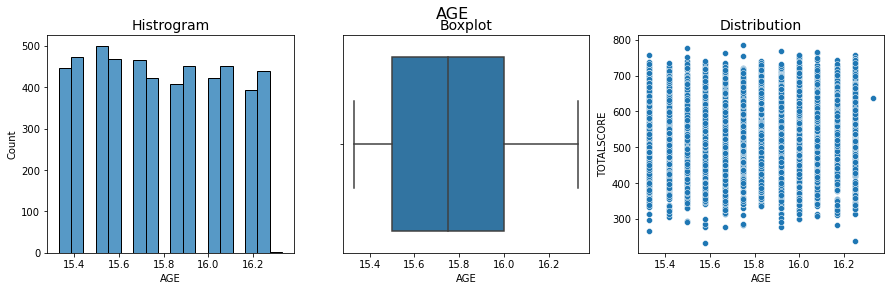

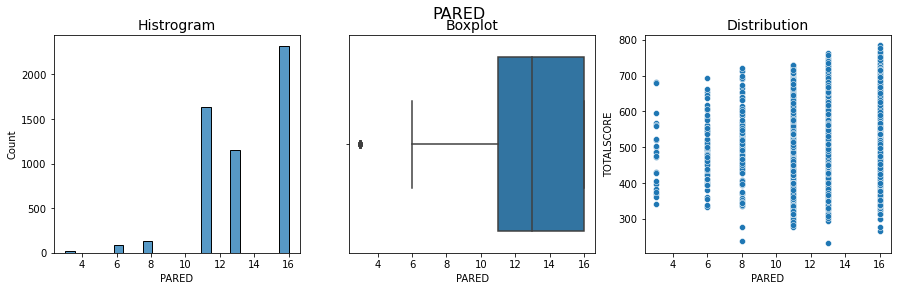

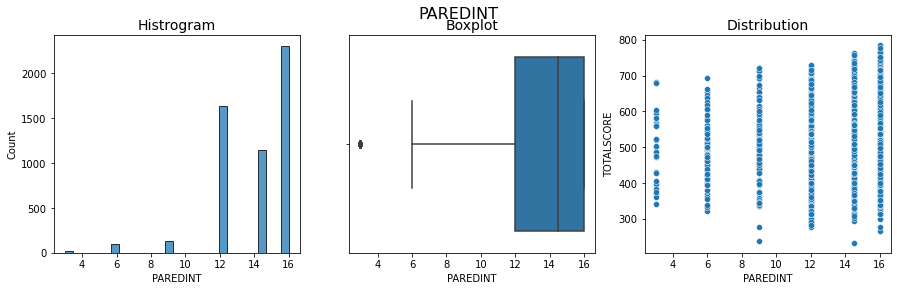

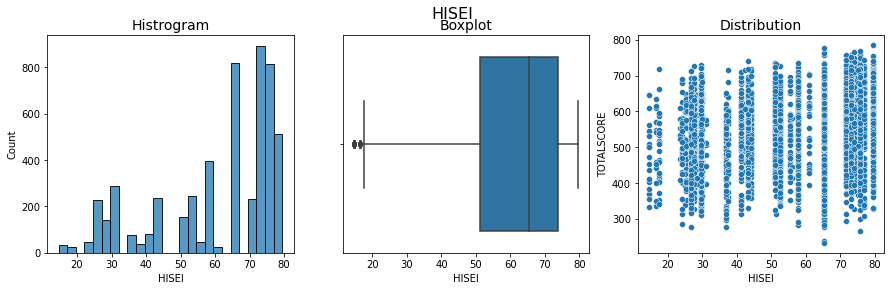

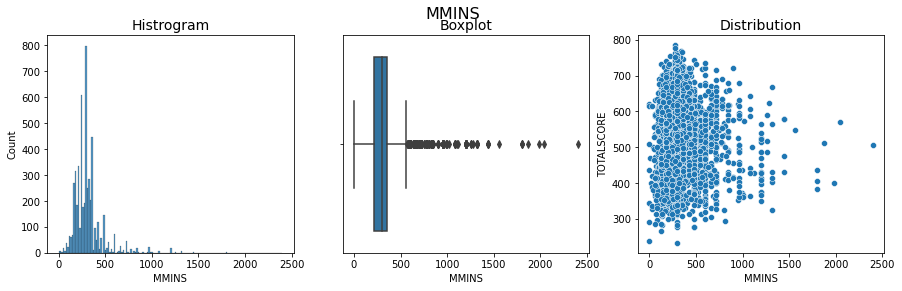

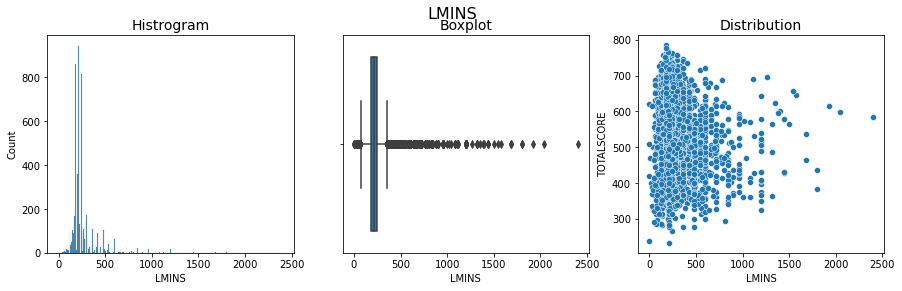

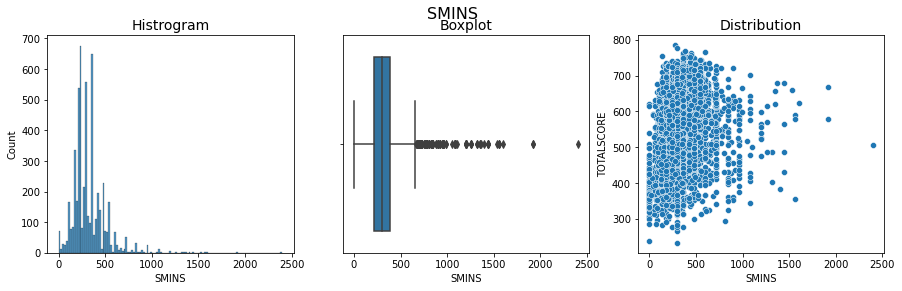

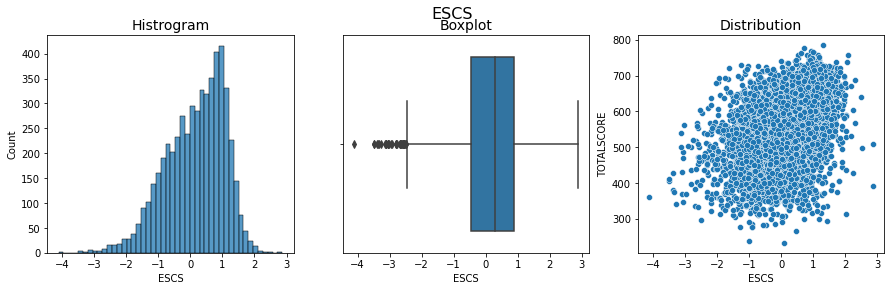

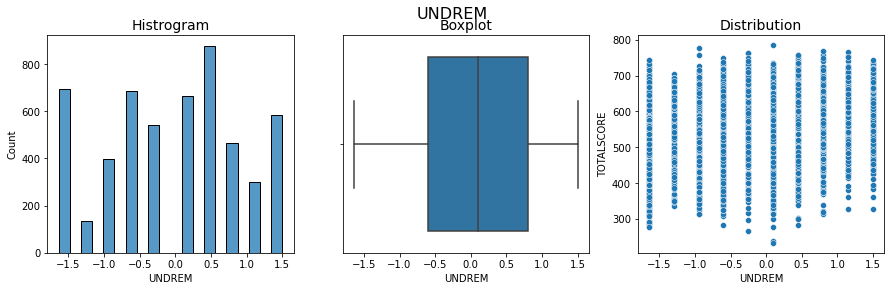

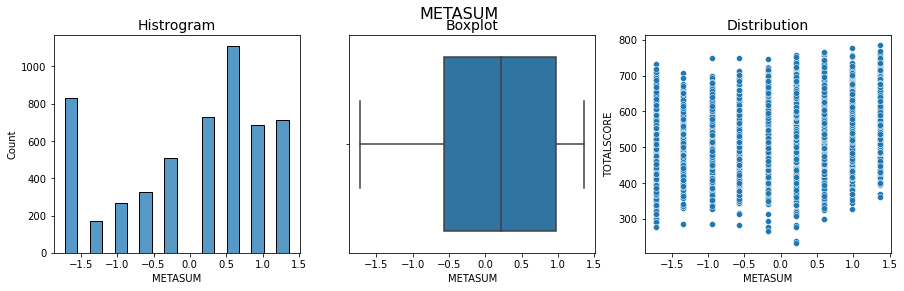

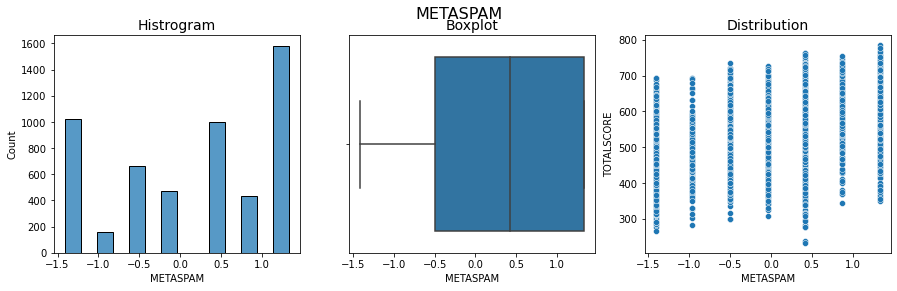

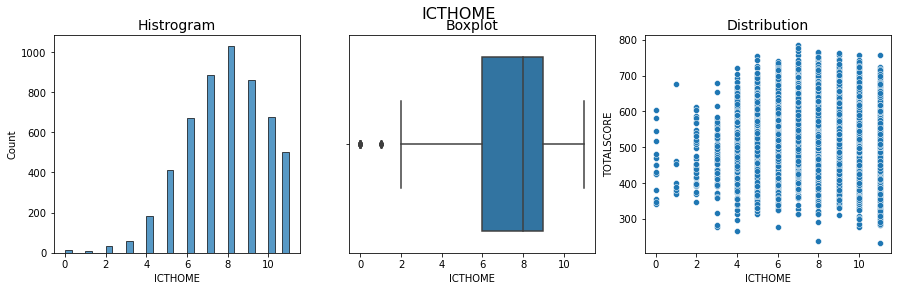

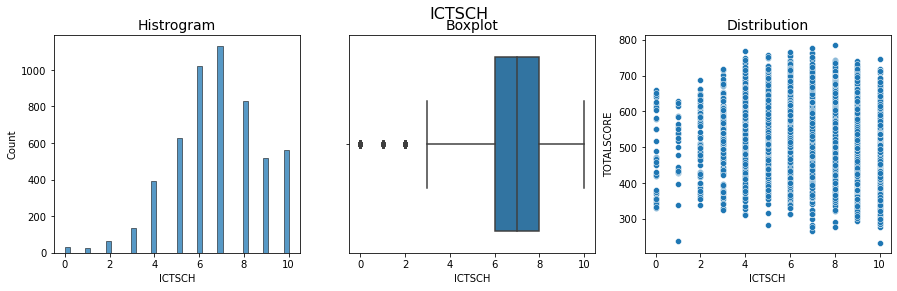

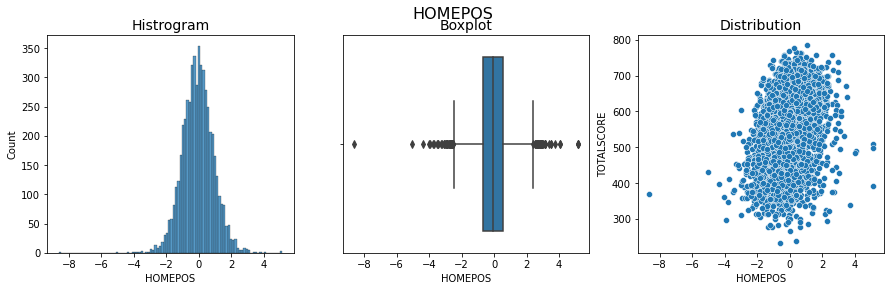

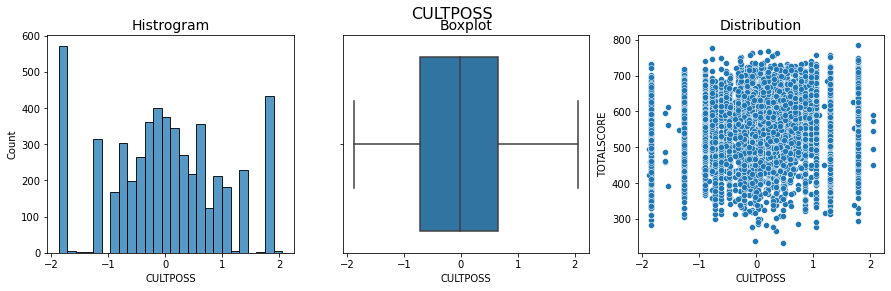

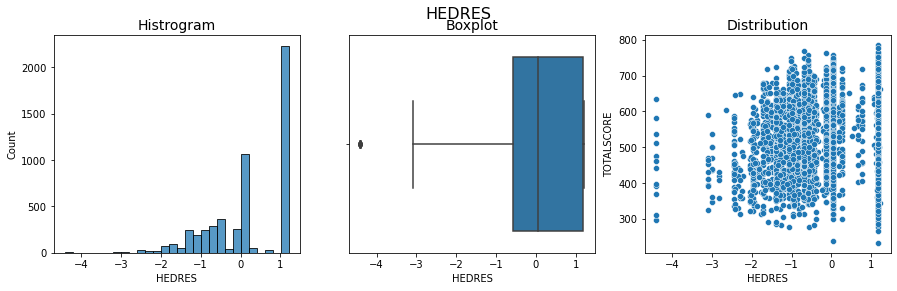

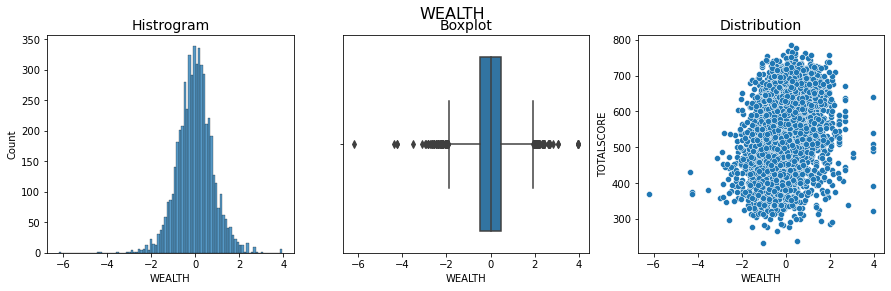

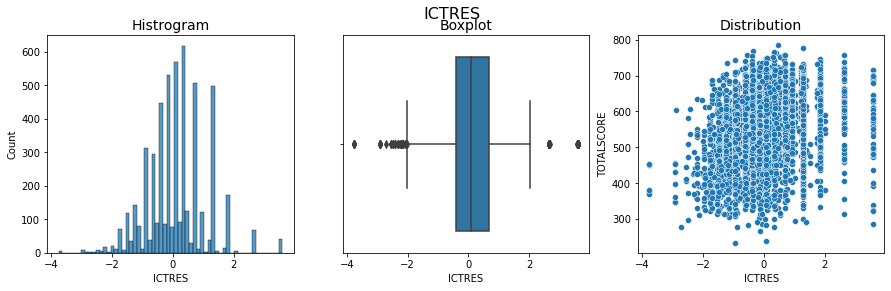

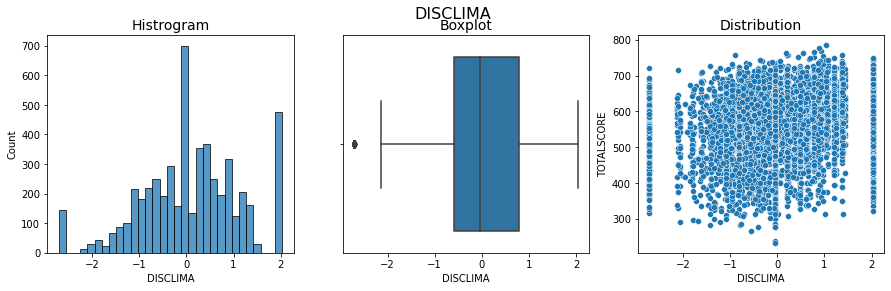

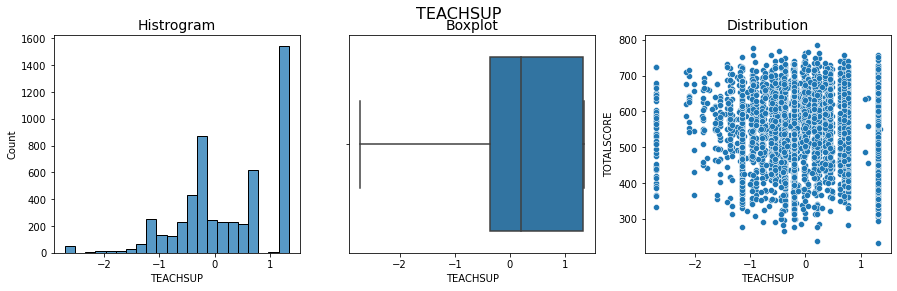

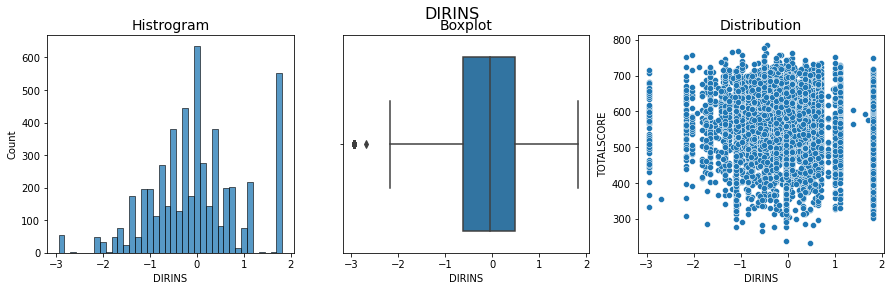

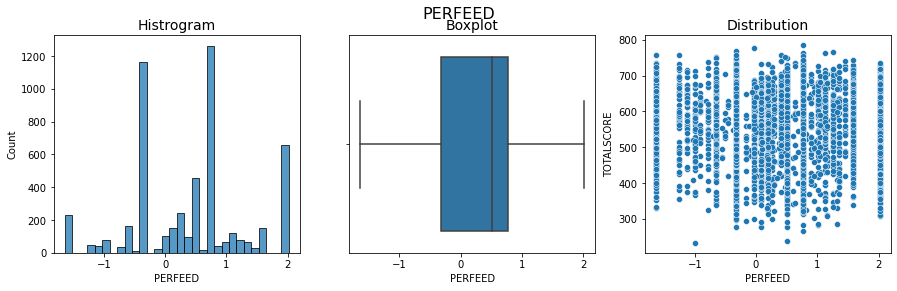

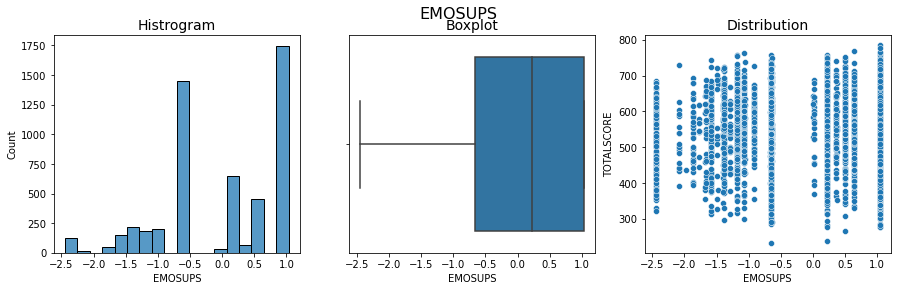

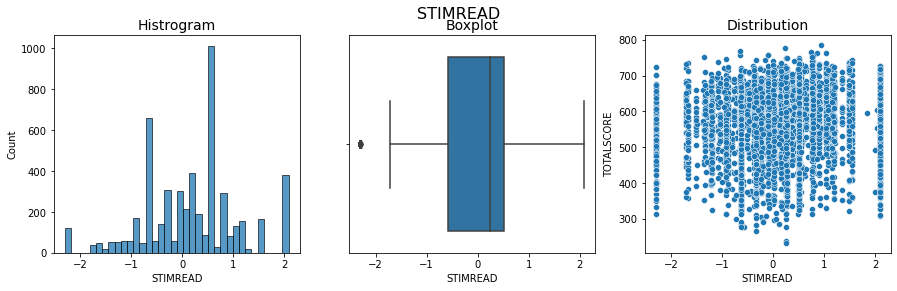

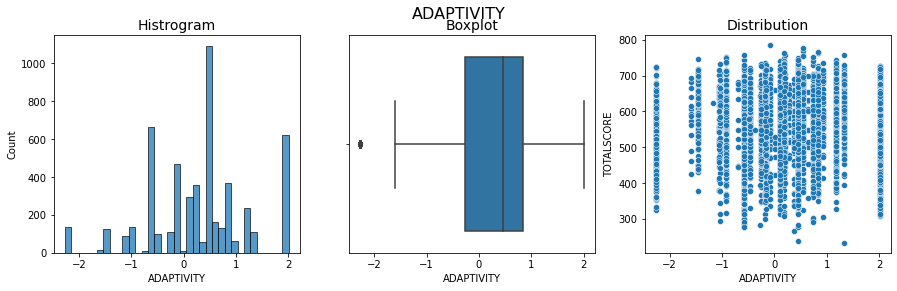

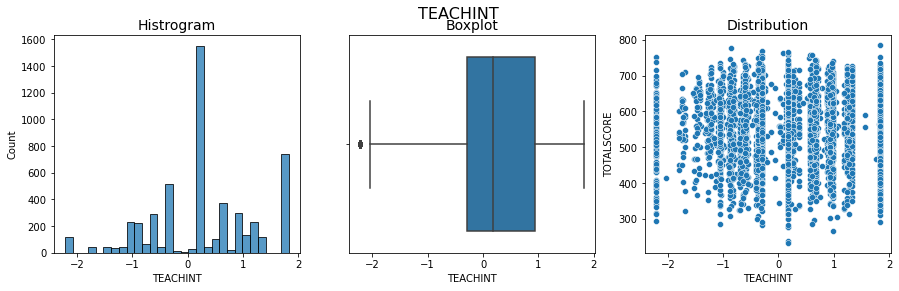

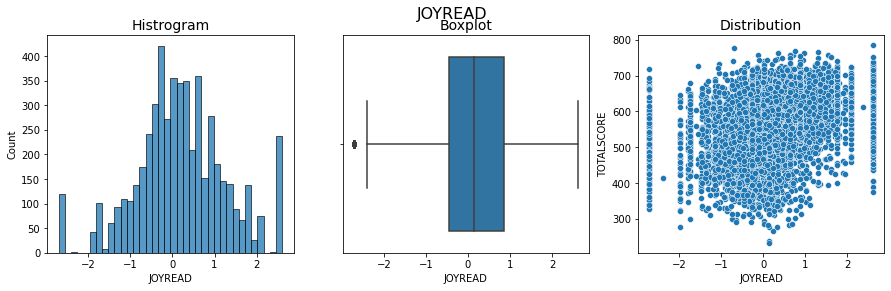

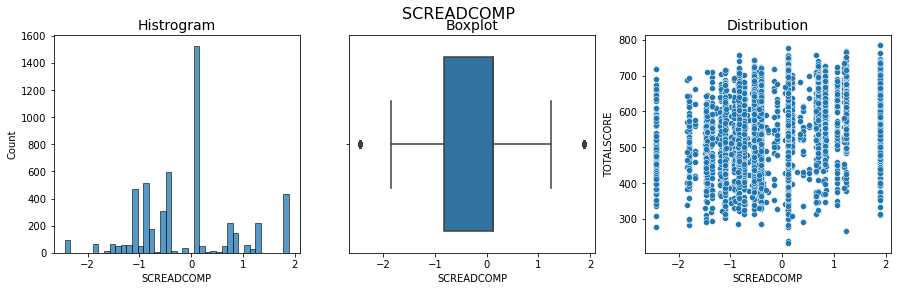

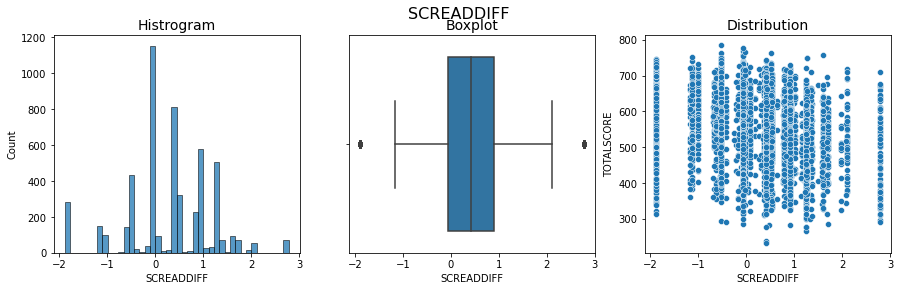

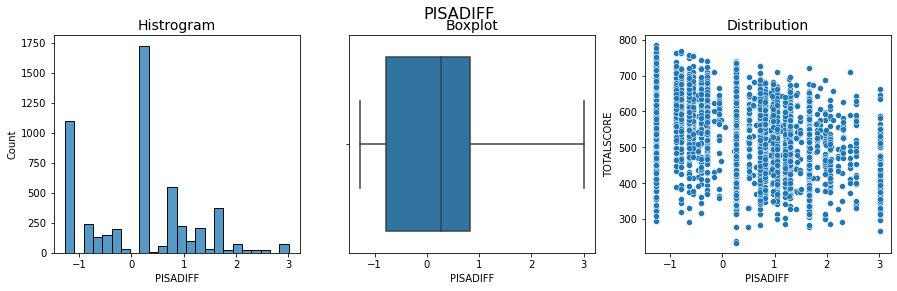

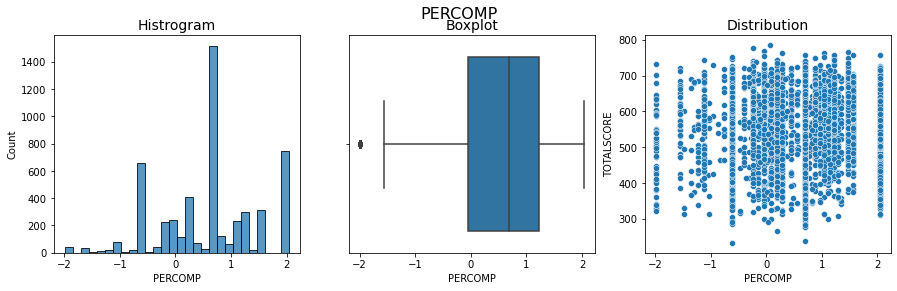

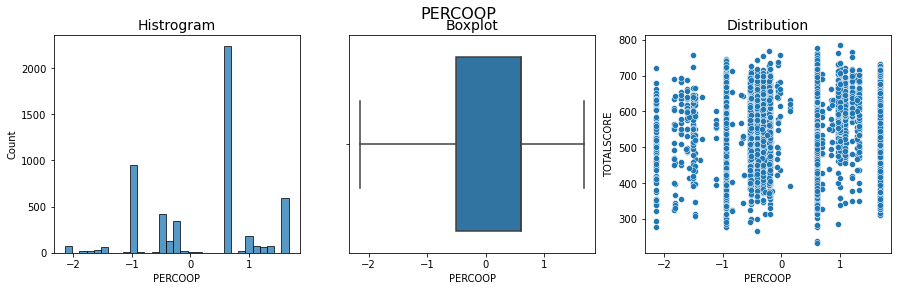

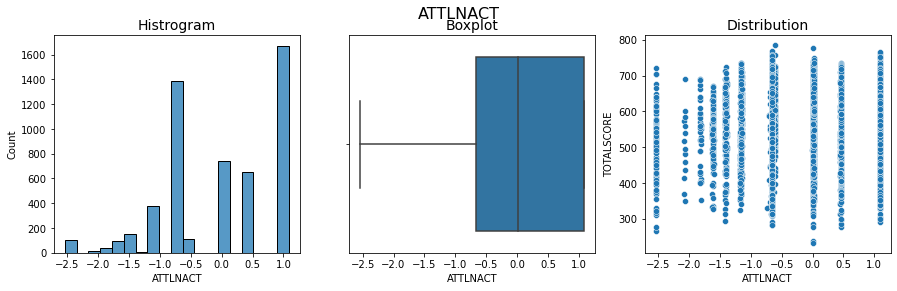

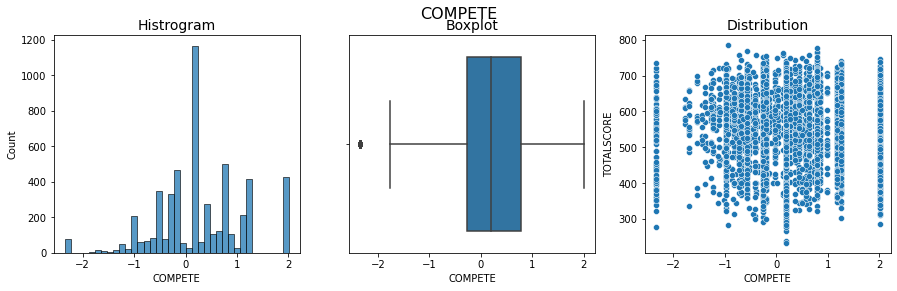

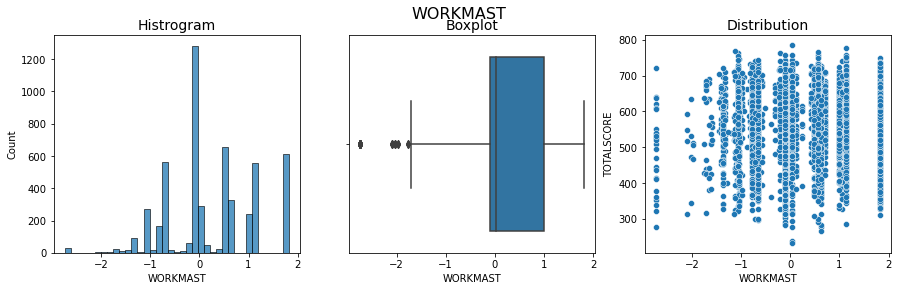

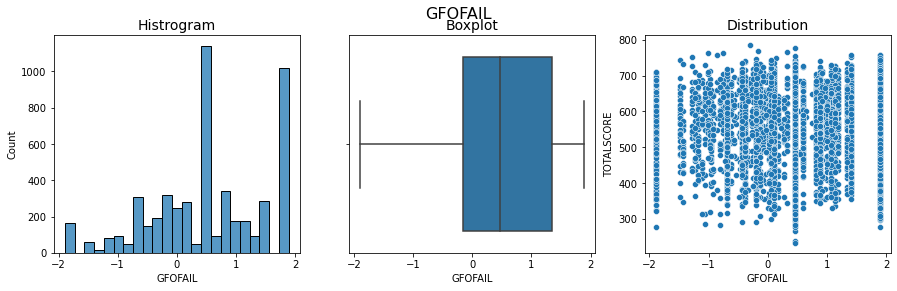

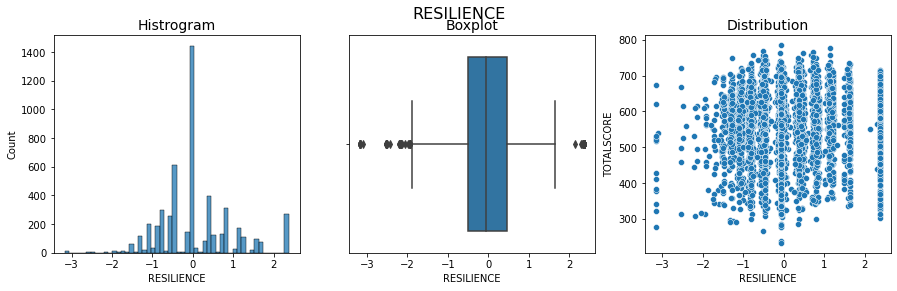

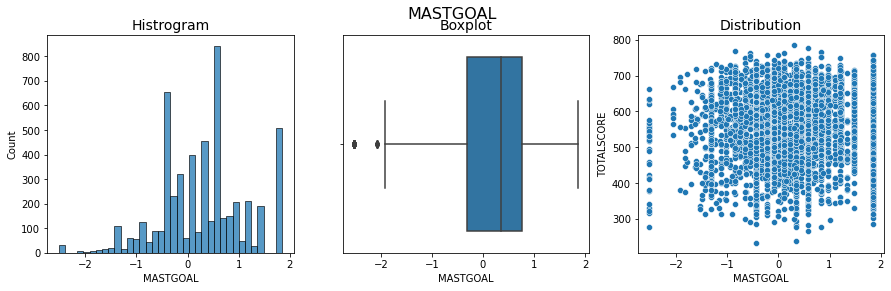

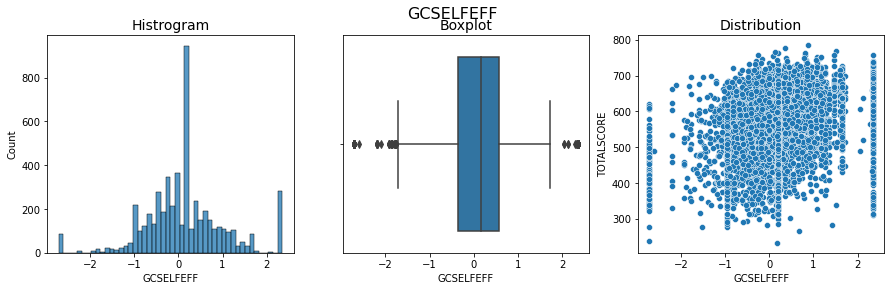

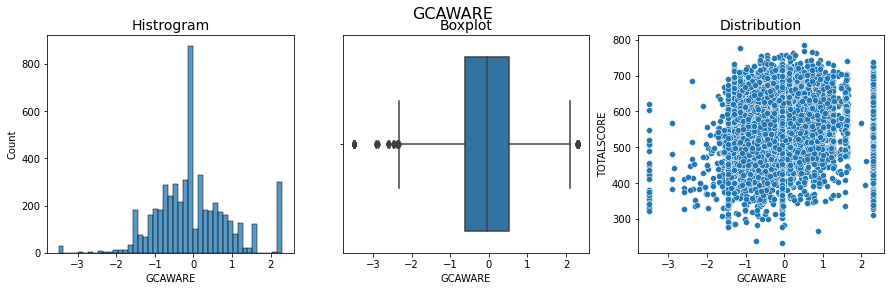

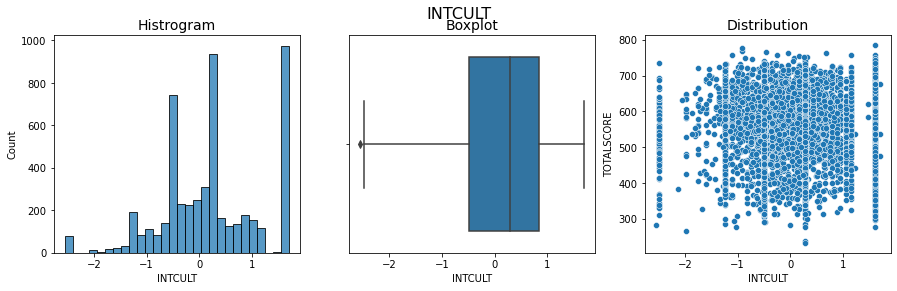

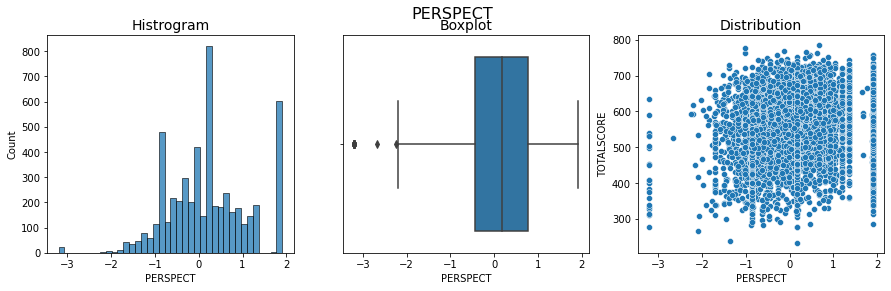

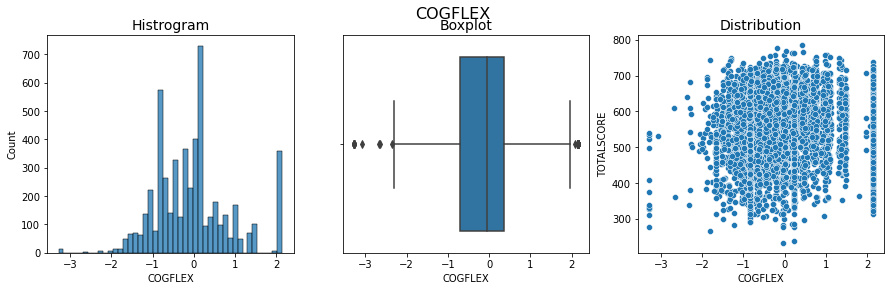

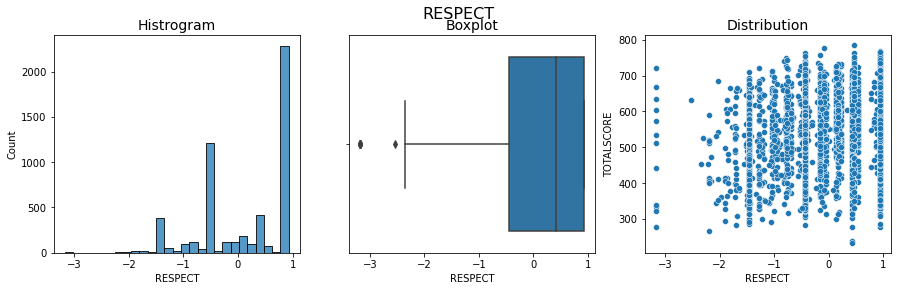

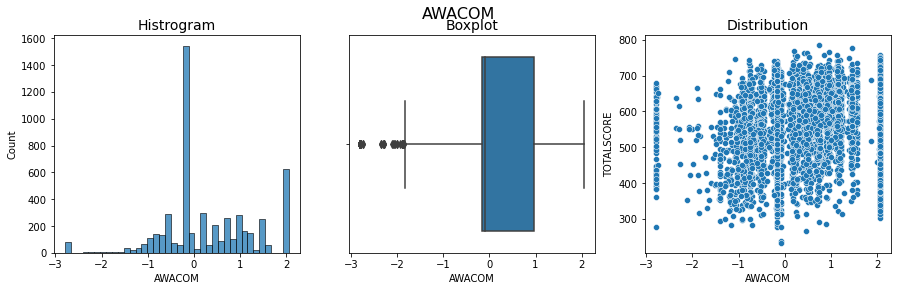

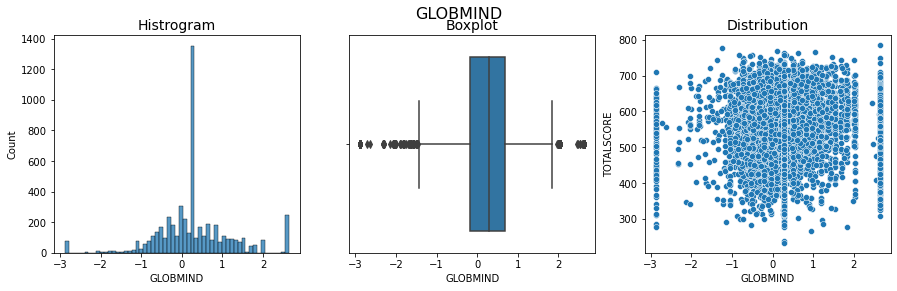

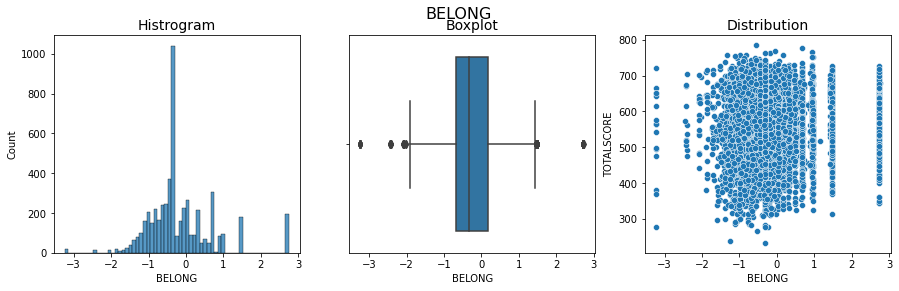

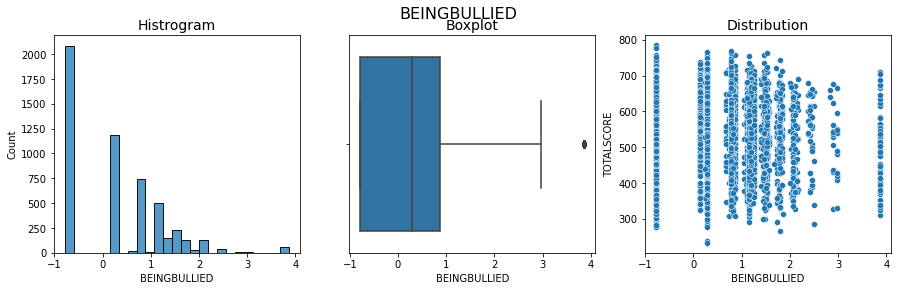

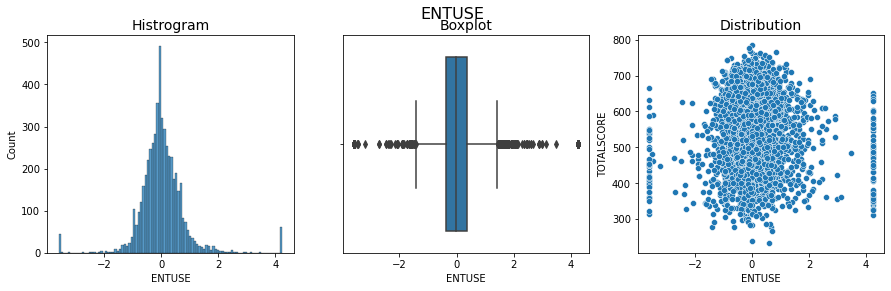

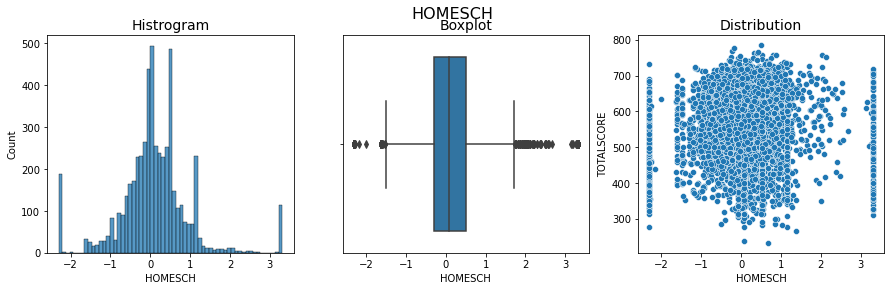

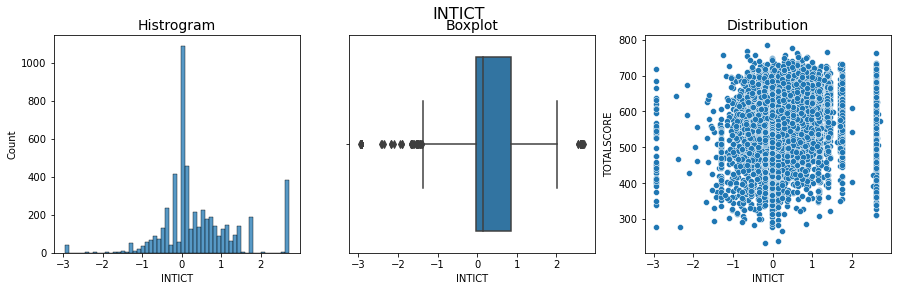

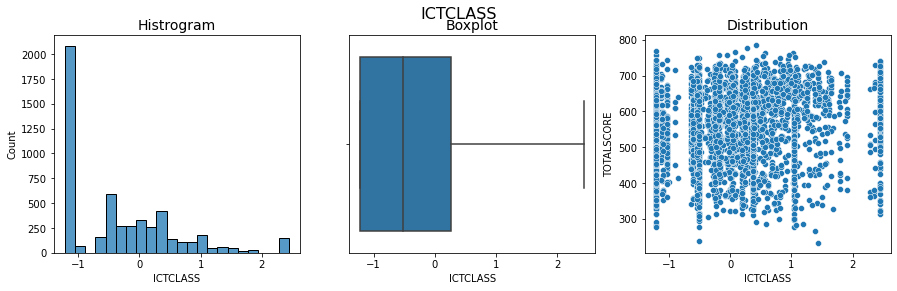

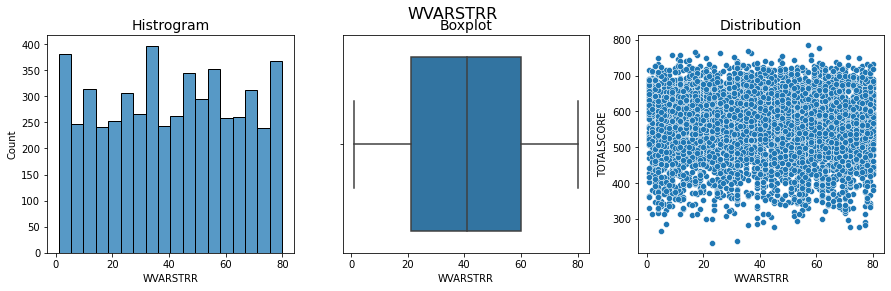

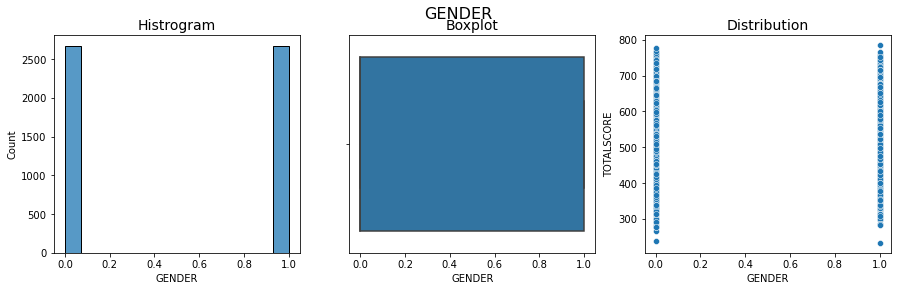

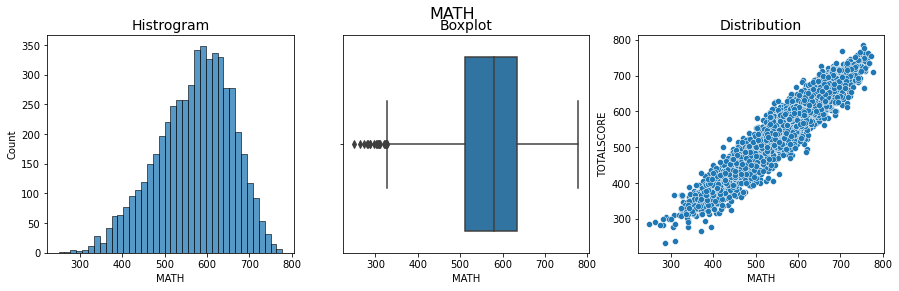

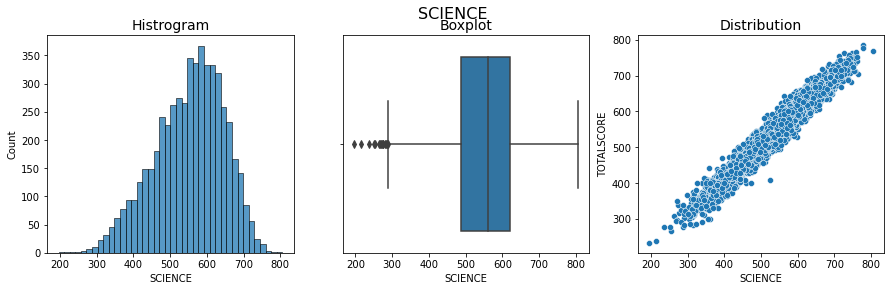

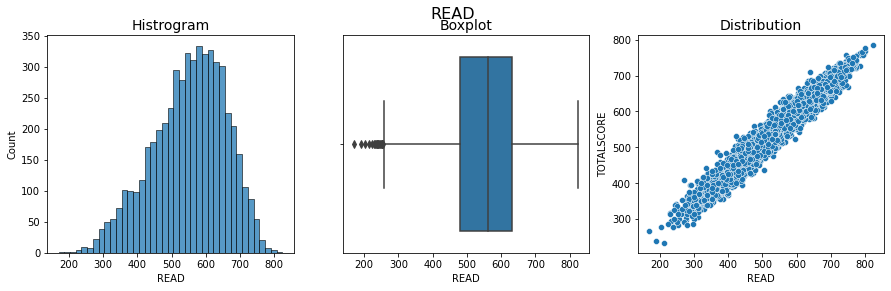

In [18]:
#Create Histrogram plot, Boxplot and Distribution plot of numerical features
numvar = train_singapore.dtypes !="object"
numeric_features = list(numvar[numvar].index)
for col in numeric_features:
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,4))
    ax = ax.ravel() 
    fig.suptitle(f"{col}\n", fontsize=16)
    ax[0].set_title(f'Histrogram', fontsize =14)
    sns.histplot(train_singapore[col], ax=ax[0])
    ax[1].set_title(f'Boxplot', fontsize =14)
    sns.boxplot(x=train_singapore[col], ax=ax[1])
    ax[2].set_title(f'Distribution', fontsize =14)
    sns.scatterplot(x = train_singapore[col], y= train_singapore['TOTALSCORE'],ax=ax[2])
    plt.show()

In [19]:
#remove extreme outliers
train_singapore = train_singapore[(train_singapore['PARED'] >4)]
train_singapore = train_singapore[(train_singapore['PAREDINT'] >4)]
train_singapore = train_singapore[(train_singapore['MMINS'] < 2000)]
train_singapore = train_singapore[(train_singapore['LMINS'] < 2000)]
train_singapore = train_singapore[(train_singapore['SMINS'] < 2000)]
train_singapore = train_singapore[(train_singapore['ESCS'] >= -3)]
train_singapore = train_singapore[(train_singapore['ICTHOME'] > 0)]
train_singapore = train_singapore[(train_singapore['HOMEPOS'] > -5)]
train_singapore = train_singapore[(train_singapore['HOMEPOS'] < 4)]
train_singapore = train_singapore[(train_singapore['HEDRES'] > -4)]
train_singapore = train_singapore[(train_singapore['WEALTH'] > -4)]
train_singapore = train_singapore[(train_singapore['ICTRES'] > -4)]
train_singapore = train_singapore[(train_singapore['WORKMAST'] > -3)]

In [20]:
train_singapore.shape, test_singapore.shape

((5274, 75), (1336, 75))

## Exploring categorical features

In [21]:
# Create a function to plot boxplot for categorical features

def subplot_boxplot(dataframe, list_of_columns):
    
    nrows = int(np.ceil(len(list_of_columns)/2)) 
    
    fig, ax = plt.subplots(nrows=nrows, ncols=2, figsize=(15,5*nrows)) 
    
    ax = ax.ravel() 
    
    if len(list_of_columns) %2 !=0:
        
        ax[len(list_of_columns)].set_visible(False)
        
    for i, column in enumerate(list_of_columns):
        
        names = train_singapore.groupby(column).mean()['TOTALSCORE'].sort_values().index
        
        sns.boxplot(x = dataframe[column],y = dataframe['TOTALSCORE'],order = names, ax = ax[i], color="#99d6ff") 
        
        ax[i].set_title(f'TOTALSCORE  vs {column}', fontsize =16)
        
        ax[i].set_ylabel('Values',fontsize=15)
        
        ax[i].set_xlabel(column,fontsize=15) 
        
        ax[i].set_xticklabels(names,rotation=40) 
        
    plt.tight_layout()

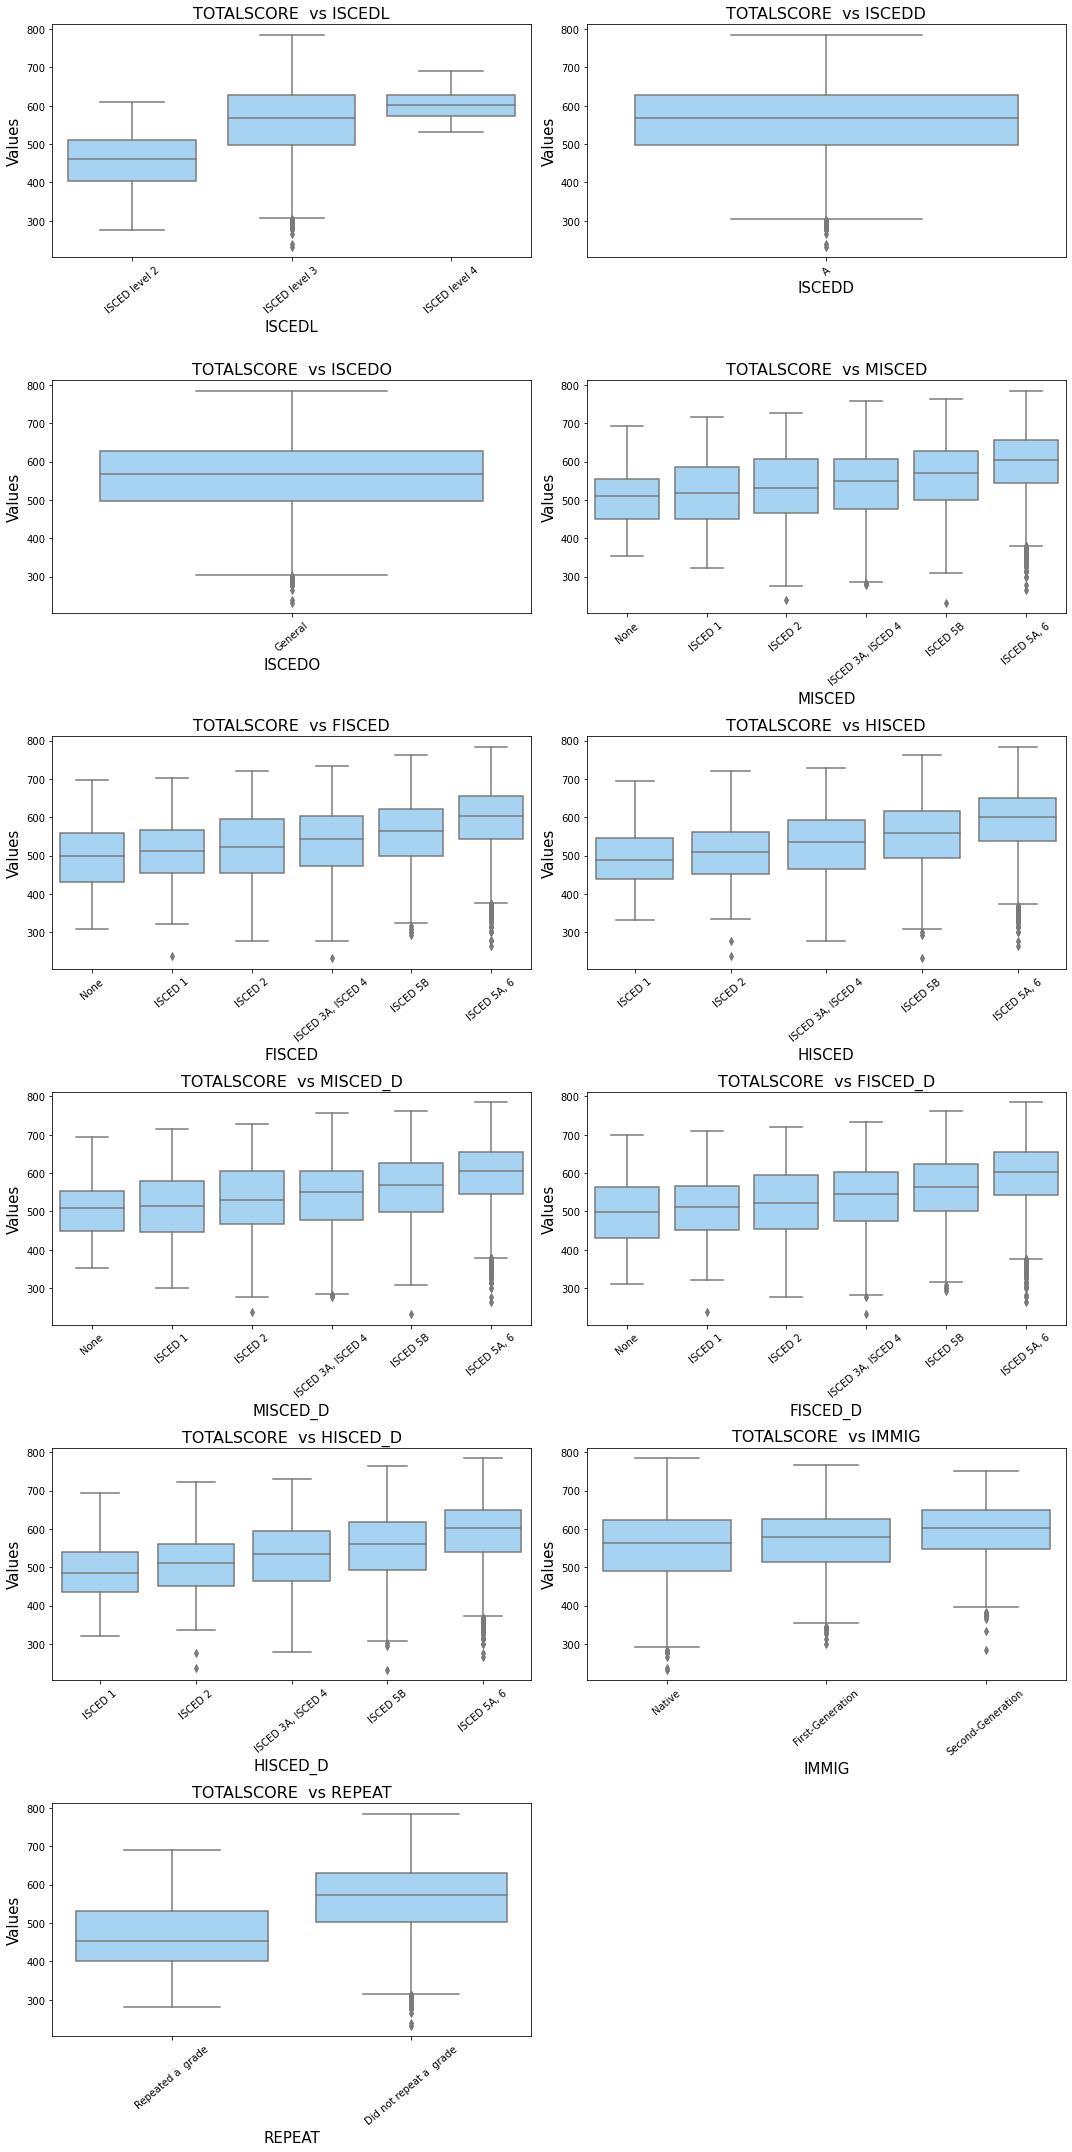

In [22]:
#Create boxplot
obvar = train_singapore.dtypes =="object"
categorical_features = list(obvar[obvar].index) 
subplot_boxplot(train_singapore, categorical_features)

According to the boxplots, some features has duplicated information. Moreover, the subgroup of 'MISCED', 'FISCED', 'HISCED' have similar means except 'ISCED 5A, 6', Thus, all subgroup will be combined into one group to reduce number of dummy codes. 

In [25]:
#Drop duplicated features 
train_singapore.drop(columns=['MISCED_D', 'FISCED_D', 'HISCED_D', 'ISCEDD','ISCEDO'], axis =1, inplace = True)
test_singapore.drop(columns=['MISCED_D', 'FISCED_D', 'HISCED_D', 'ISCEDD','ISCEDO'], axis =1, inplace = True)

In [26]:
#Grouping values of categorical columns to reduce number of categories. 
train_singapore['Is_MISCED_5A,6'] = np.where(train_singapore['MISCED'] == 'ISCED 5A, 6', 1, 0)
train_singapore['Is_FISCED_5A,6'] = np.where(train_singapore['FISCED'] == 'ISCED 5A, 6', 1, 0)
train_singapore['Is_HISCED_5A,6'] = np.where(train_singapore['HISCED'] == 'ISCED 5A, 6', 1, 0)

In [27]:
#Grouping values of categorical columns to reduce number of categories. 
test_singapore['Is_MISCED_5A,6'] = np.where(test_singapore['MISCED'] == 'ISCED 5A, 6', 1, 0)
test_singapore['Is_FISCED_5A,6'] = np.where(test_singapore['FISCED'] == 'ISCED 5A, 6', 1, 0)
test_singapore['Is_HISCED_5A,6'] = np.where(test_singapore['HISCED'] == 'ISCED 5A, 6', 1, 0)

In [28]:
#Drop original columns
train_singapore.drop(columns= ['MISCED', 'FISCED', 'HISCED'], axis =1, inplace =True)
test_singapore.drop(columns= ['MISCED', 'FISCED', 'HISCED'], axis =1, inplace =True)

## Explore relationship among features

<AxesSubplot:>

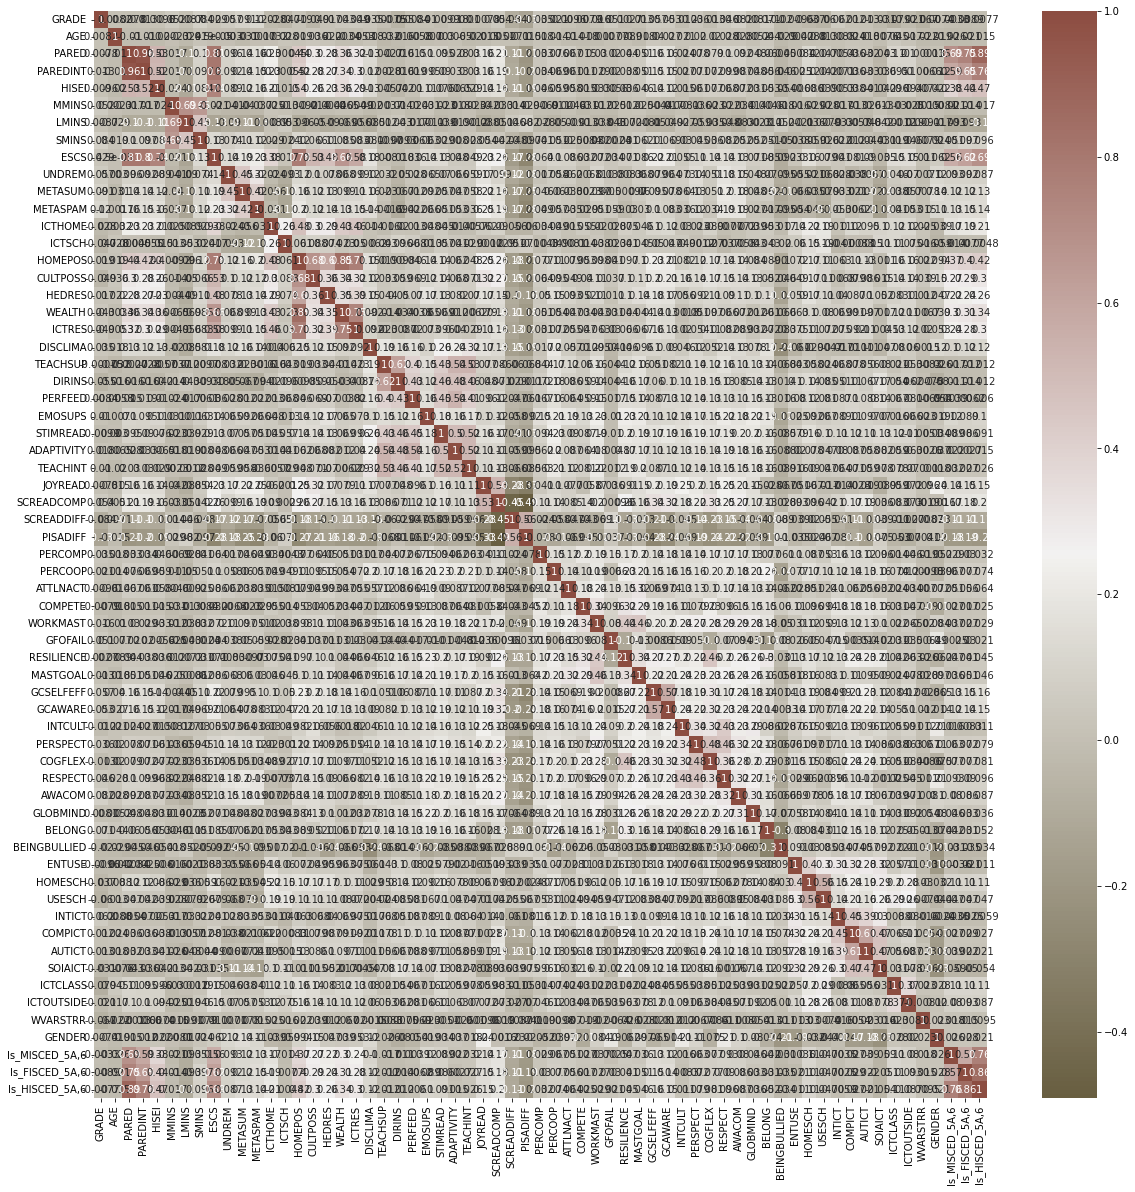

In [30]:
#Checking collinearity using correlation matrix
train_singapore_cormatrix = train_singapore.drop(columns= ['MATH','SCIENCE','READ','TOTALSCORE',], axis =1)
cmap = sns.diverging_palette(70,20,s=50, l=40, n=6,as_cmap=True)
corrmat= train_singapore_cormatrix.corr()
f, ax = plt.subplots(figsize=(20,20))
sns.heatmap(corrmat,cmap=cmap,annot=True, )

In [33]:
# Drop columns with high correlation 
#Create correlation matrix
corr_matrix = train_singapore_cormatrix.corr().abs()
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.85)]
print(f' Features to drop : {to_drop}')

 Features to drop : ['PAREDINT', 'WEALTH', 'Is_HISCED_5A,6']


In [34]:
# Drop features with high correlation among themselves
train_singapore.drop(to_drop, axis=1, inplace=True)
test_singapore.drop(to_drop, axis=1, inplace=True)
train_singapore.shape, test_singapore.shape

((5274, 67), (1336, 67))

## Exploring target variables

In [35]:
train_singapore[['MATH','READ', 'SCIENCE','TOTALSCORE']].describe().round(2)

MATH     READ  SCIENCE  TOTALSCORE
count  5274.00  5274.00  5274.00     5274.00
mean    570.35   551.57   552.55      558.16
std      87.80   106.17    93.09       92.70
min     249.16   169.94   196.01      232.33
25%     512.68   482.53   489.34      497.63
50%     580.46   561.70   562.84      568.10
75%     634.79   630.79   621.92      627.36
max     777.50   823.40   805.27      784.57

<Figure size 432x432 with 0 Axes>

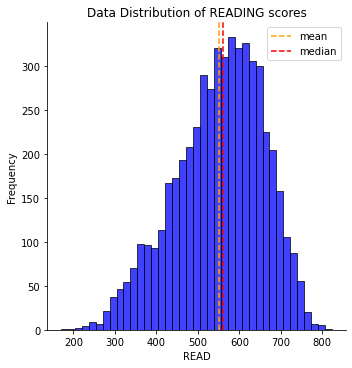

In [36]:
#Check data distribution of READING scores
plt.figure(figsize=(6,6))

sns.displot(train_singapore['READ'], color='b')

plt.ylabel('Frequency')

plt.title('Data Distribution of READING scores')

plt.axvline(train_singapore['READ'].mean(), linestyle = '--', color = 'orange', label ='mean')

plt.axvline(train_singapore['READ'].median(), linestyle = '--', color = 'r', label ='median')

plt.legend();


In [37]:
#Check data distribution of SCIENCE scores
plt.figure(figsize=(6,6))

sns.displot(train_singapore['SCIENCE'], color='b')

plt.ylabel('Frequency')

plt.title('Data Distribution of SCIENCE scores')

plt.axvline(train_singapore['SCIENCE'].mean(), linestyle = '--', color = 'orange', label ='mean')

plt.axvline(train_singapore['SCIENCE'].median(), linestyle = '--', color = 'r', label ='median')

plt.legend();

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

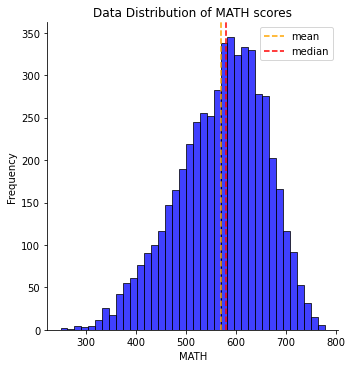

In [38]:
#Check data distribution of MATH scores
plt.figure(figsize=(6,6))

sns.displot(train_singapore['MATH'], color='b')

plt.ylabel('Frequency')

plt.title('Data Distribution of MATH scores')

plt.axvline(train_singapore['MATH'].mean(), linestyle = '--', color = 'orange', label ='mean')

plt.axvline(train_singapore['MATH'].median(), linestyle = '--', color = 'r', label ='median')

plt.legend();

<Figure size 432x432 with 0 Axes>

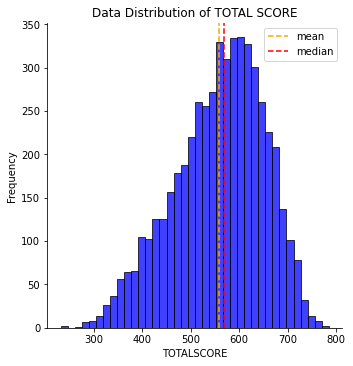

In [39]:
#Check data distribution of TOTALSCORE
plt.figure(figsize=(6,6))

sns.displot(train_singapore['TOTALSCORE'], color='b')

plt.ylabel('Frequency')

plt.title('Data Distribution of TOTAL SCORE')

plt.axvline(train_singapore['TOTALSCORE'].mean(), linestyle = '--', color = 'orange', label ='mean')

plt.axvline(train_singapore['TOTALSCORE'].median(), linestyle = '--', color = 'r', label ='median')

plt.legend();

All 'MATH','READ', 'SCIENCE', and 'TOTALSCORE' scores are slightly right skew. Average score of MATH is highest. In this study, TOTALSCORE will be the main target.

## Exploring correlations between features and the target variable

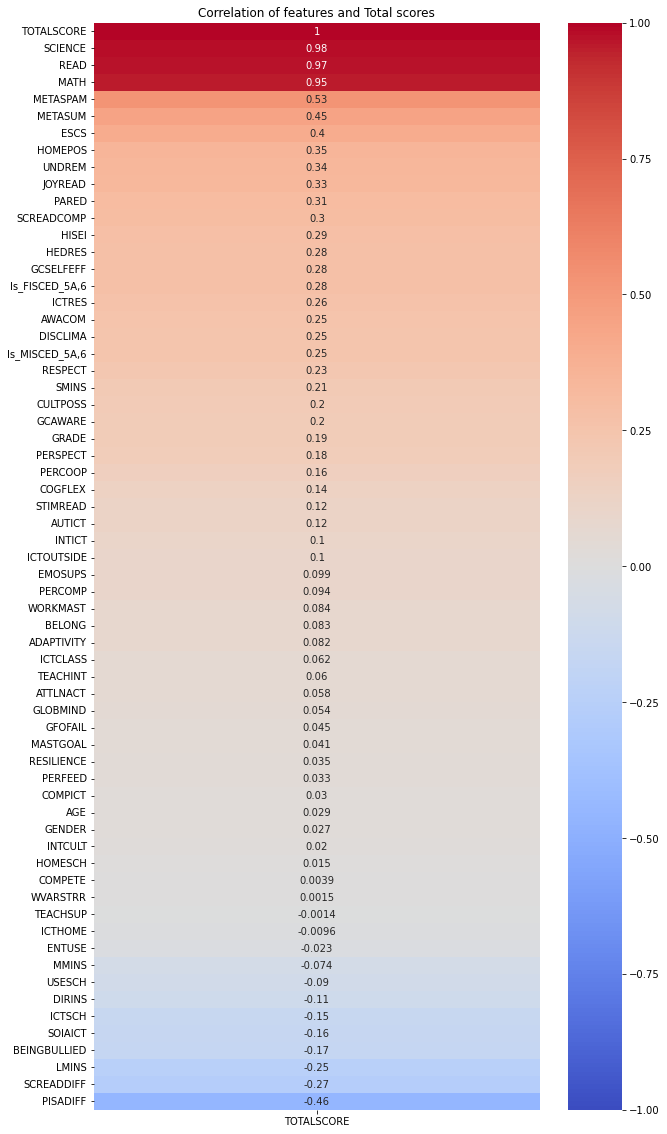

In [40]:
#Heatmap of correlation between features and TOTALSCORE
plt.figure(figsize = (10,20))
sns.heatmap(train_singapore.corr()[['TOTALSCORE']].sort_values(by = 'TOTALSCORE', ascending = False), 
                cmap = 'coolwarm',
                vmax = 1,
                vmin = -1,
                annot = True)
plt.title('Correlation of features and Total scores')

plt.yticks(rotation =0)
plt.show()

Due to too many features in building a model in this dataset, and the aim of this study is to explore features that impact PISA score. Thus, only features whcih have higher correlation with the target variable will be used in the models.

In [41]:
#Select features which have correlation above 0.20 or below -0.20 
selectd_features = (train_singapore.corr()[['TOTALSCORE']] > 0.20) | (train_singapore.corr()[['TOTALSCORE']] < -0.20)
selectd_features[selectd_features['TOTALSCORE']==True].index.values

array(['PARED', 'HISEI', 'LMINS', 'SMINS', 'ESCS', 'UNDREM', 'METASUM',
       'METASPAM', 'HOMEPOS', 'HEDRES', 'ICTRES', 'DISCLIMA', 'JOYREAD',
       'SCREADCOMP', 'SCREADDIFF', 'PISADIFF', 'GCSELFEFF', 'RESPECT',
       'AWACOM', 'MATH', 'SCIENCE', 'READ', 'TOTALSCORE',
       'Is_MISCED_5A,6', 'Is_FISCED_5A,6'], dtype=object)

In [42]:
obvar = train_singapore.dtypes =="object"
categorical_features = list(obvar[obvar].index) 
categorical_features

['ISCEDL', 'IMMIG', 'REPEAT']

In [45]:
#Save files for another study.
train_singapore.to_csv('train_pisa2018_singapore.csv')
test_singapore.to_csv('test_pisa2018_singapore.csv')

# Building Regressor Models

In [44]:
#Assemble our X and y variables
X_train =train_singapore[['PARED', 'HISEI', 'LMINS', 'SMINS', 'ESCS', 'UNDREM', 'METASUM',
       'METASPAM', 'HOMEPOS', 'HEDRES', 'ICTRES', 'DISCLIMA', 'JOYREAD',
       'SCREADCOMP', 'SCREADDIFF', 'PISADIFF', 'GCSELFEFF', 'RESPECT','AWACOM',
       'Is_MISCED_5A,6', 'Is_FISCED_5A,6', 'ISCEDL', 'IMMIG', 'REPEAT', 'GENDER']]
X_train = pd.get_dummies(columns=['Is_MISCED_5A,6', 'Is_FISCED_5A,6', 'ISCEDL', 'IMMIG', 'REPEAT', 'GENDER'], 
                         drop_first =True, data =X_train)
y_train = train_singapore['TOTALSCORE']

X_test =test_singapore[['PARED', 'HISEI', 'LMINS', 'SMINS', 'ESCS', 'UNDREM', 'METASUM',
       'METASPAM', 'HOMEPOS', 'HEDRES', 'ICTRES', 'DISCLIMA', 'JOYREAD',
       'SCREADCOMP', 'SCREADDIFF', 'PISADIFF', 'GCSELFEFF', 'RESPECT','AWACOM',
       'Is_MISCED_5A,6', 'Is_FISCED_5A,6', 'ISCEDL', 'IMMIG', 'REPEAT', 'GENDER']]
X_test = pd.get_dummies(columns=['Is_MISCED_5A,6', 'Is_FISCED_5A,6', 'ISCEDL', 'IMMIG', 'REPEAT', 'GENDER'], 
                         drop_first =True, data =X_test)
y_test = test_singapore['TOTALSCORE']

## Dummy Regressor model

In [46]:
from sklearn.dummy import DummyRegressor
baseline_model = DummyRegressor()
baseline_model.fit(X_train, y_train)
baseline_preds = baseline_model.predict(X_test)
# Test Score
baseline_model.score(X_test, y_test)
print(f'Test R-squared Score: {baseline_model.score(X_test, y_test)}')
#evaluate models with matrics
print(f'MSE is : {mean_squared_error(y_test, baseline_preds)}' )
print(f'RMSE is : {mean_squared_error(y_test, baseline_preds, squared = False)}' )

Test R-squared Score: -0.007971018707029875
MSE is : 8835.12843679317
RMSE is : 93.99536391116942


## Linear Regression model

In [47]:
lr = LinearRegression()
lr.fit(X_train, y_train)

# Train Score
lr.score(X_train, y_train)
print(f'Train R-squared Score: {lr.score(X_train, y_train)}')

# Test Score
lr.score(X_test, y_test)
print(f'Test R-squared Score: {lr.score(X_test, y_test)}')

# Cross Val Score
cross_val_score(lr, X_train, y_train, cv =5)
print(f' Cross Val Score :{cross_val_score(lr, X_train, y_train, cv =5)}')
print()
# Making prediction
y_preds = lr.predict(X_test)

#evaluate models with matrics
print(f'MSE is : {mean_squared_error(y_test, y_preds)}' )
print(f'RMSE is : {mean_squared_error(y_test, y_preds, squared = False)}' )

Train R-squared Score: 0.5642823020668949
Test R-squared Score: 0.5466607602346929
 Cross Val Score :[0.55119963 0.56603316 0.57103908 0.56025362 0.54332429]

MSE is : 3973.636478063084
RMSE is : 63.0367867047733


In [48]:
lr.intercept_

545.6989232718126

In [49]:
pd.Series(lr.coef_, index = X_train.columns).sort_values(ascending=False)

METASPAM                    23.508265
ISCEDL_ISCED level 3        21.472543
ESCS                        14.052546
METASUM                     13.128445
IMMIG_Second-Generation     11.662522
JOYREAD                      7.954025
GCSELFEFF                    7.916360
UNDREM                       7.427054
Is_FISCED_5A,6_1             6.105289
DISCLIMA                     5.040733
HEDRES                       4.866983
Is_MISCED_5A,6_1             3.886218
ICTRES                       3.703520
AWACOM                       2.810865
RESPECT                      1.957087
SCREADDIFF                   1.270343
SMINS                        0.106092
HISEI                        0.015621
IMMIG_Native                -0.122290
LMINS                       -0.136273
PARED                       -1.110290
SCREADCOMP                  -2.581360
HOMEPOS                     -4.801391
GENDER_1                   -14.647002
PISADIFF                   -16.684009
ISCEDL_ISCED level 4       -42.706775
REPEAT_Repea

#### Getting stadardized coefficients

In [50]:
scaler = StandardScaler()  #scaler object
X_train_sc = scaler.fit_transform(X_train)  #scaling training set
X_test_sc = scaler.transform(X_test)  #scaling test set

lr = LinearRegression()
lr.fit(X_train_sc, y_train)
y_preds = lr.predict(X_test_sc)

In [51]:
# coefficient dataframe
lr_coef = pd.DataFrame(data=[lr.coef_],columns=X_train.columns).T.sort_values(by=0,ascending=False)

# Label the color the each coefficient
color = ['red' if x < 0 else 'blue' for x in lr_coef[0]]

# Assign the color_list to new column
lr_coef['color'] = color

lr_coef.head()

0 color
METASPAM  23.797623  blue
SMINS     18.350753  blue
METASUM   13.290062  blue
ESCS      12.411589  blue
JOYREAD    8.531714  blue

In [52]:
# Select the highest values whether negative or positive
abs(lr_coef[0]).sort_values(ascending=False)[:10].index

Index(['METASPAM', 'LMINS', 'SMINS', 'PISADIFF', 'METASUM', 'ESCS',
       'REPEAT_Repeated a  grade', 'JOYREAD', 'GENDER_1', 'GCSELFEFF'],
      dtype='object')

Text(0.5, 1.0, 'Top 10 highest coefficient')

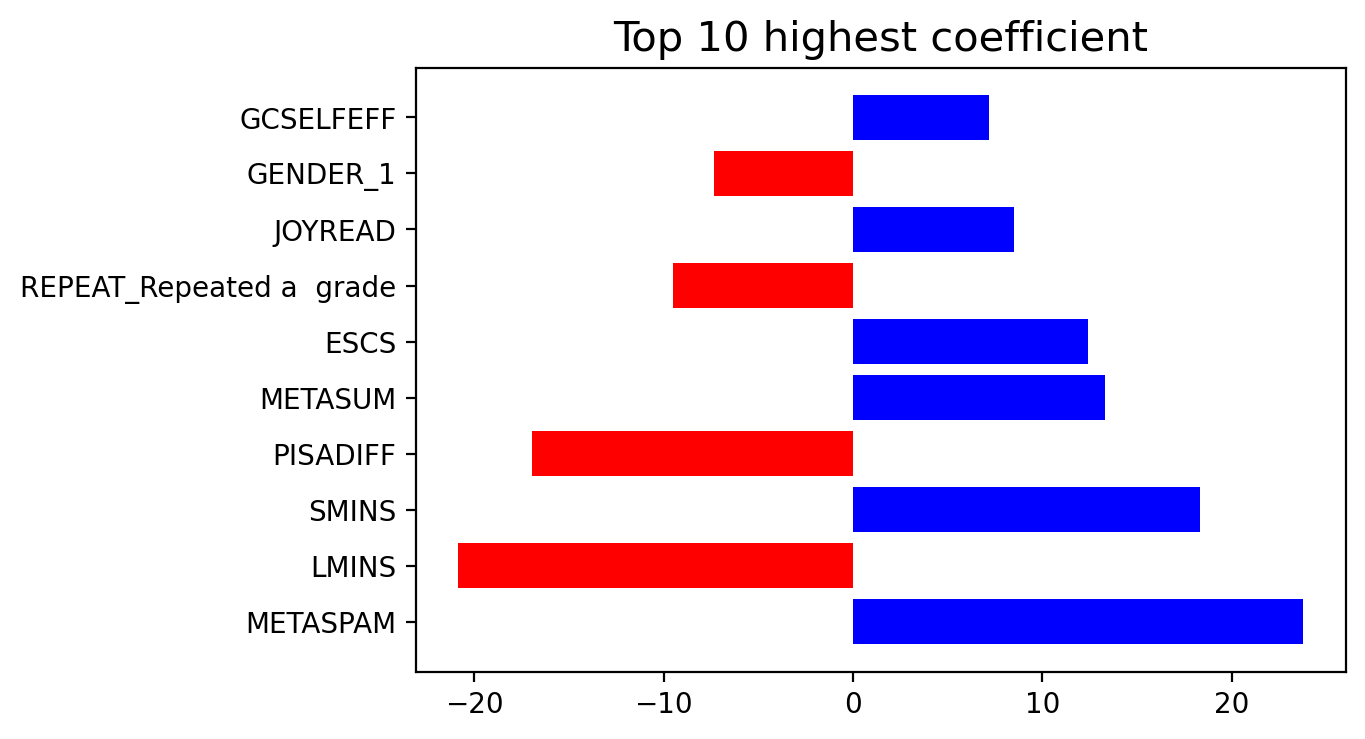

In [53]:
# Plot the coefficient of top 10 highest coefficient 
plt.figure(dpi=200)
plt.barh(lr_coef.loc[['METASPAM', 'LMINS', 'SMINS', 'PISADIFF', 'METASUM', 'ESCS',
       'REPEAT_Repeated a  grade', 'JOYREAD', 'GENDER_1', 'GCSELFEFF']].
         index,lr_coef.loc[['METASPAM', 'LMINS', 'SMINS', 'PISADIFF', 'METASUM', 'ESCS',
       'REPEAT_Repeated a  grade', 'JOYREAD', 'GENDER_1', 'GCSELFEFF']][0],
         color=lr_coef.loc[['METASPAM', 'LMINS', 'SMINS', 'PISADIFF', 'METASUM', 'ESCS',
       'REPEAT_Repeated a  grade', 'JOYREAD', 'GENDER_1', 'GCSELFEFF']]['color'])
plt.title('Top 10 highest coefficient',size=15)

## Random Forest Regressor

In [54]:
parameters = {
    'n_estimators': [100, 150, 200, 250, 300],
    'max_depth': [2,3,4]
}
regr = RandomForestRegressor(random_state=42)

clf = GridSearchCV(regr, parameters)
clf.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestRegressor(random_state=42),
             param_grid={'max_depth': [2, 3, 4],
                         'n_estimators': [100, 150, 200, 250, 300]})

In [55]:
clf.best_params_

{'max_depth': 4, 'n_estimators': 200}

In [56]:
clf.score(X_train, y_train)

0.5074212337757924

In [57]:
clf.score(X_test, y_test)

0.47040478786576356

In [58]:
# Making prediction
y_preds_clf = clf.predict(X_test)

#evaluate models with matrics
print(f'RFReg MSE is : {mean_squared_error(y_test, y_preds_clf)}' )
print(f'RFReg RMSE is : {mean_squared_error(y_test, y_preds_clf, squared = False)}' )

RFReg MSE is : 4642.039931583273
RFReg RMSE is : 68.13251743171737


In [59]:
clf.best_estimator_

RandomForestRegressor(max_depth=4, n_estimators=200, random_state=42)

In [60]:
pd.DataFrame(clf.cv_results_).sort_values('rank_test_score').head(5)[['params','param_max_depth','mean_test_score']]

params param_max_depth  mean_test_score
12  {'max_depth': 4, 'n_estimators': 200}               4         0.476283
10  {'max_depth': 4, 'n_estimators': 100}               4         0.476217
13  {'max_depth': 4, 'n_estimators': 250}               4         0.476211
11  {'max_depth': 4, 'n_estimators': 150}               4         0.475981
14  {'max_depth': 4, 'n_estimators': 300}               4         0.475812

## Support Vector Mechine: SVM

In [61]:
#Building SVM model need standardized data
scaler = StandardScaler()

X_train_sc = scaler.fit_transform(X_train)

X_test_sc = scaler.transform(X_test)

#SVM
SVM = svm.SVR().fit(X_train_sc, y_train)
# Train Score
SVM.score(X_train_sc, y_train)
print(f'SVM Train R-squared Score: {SVM.score(X_train_sc, y_train)}')
print()

# Test Score
SVM.score(X_test_sc, y_test)
print(f'SVM Test R-squared Score: {SVM.score(X_test_sc, y_test)}')

# Cross Val Score
cross_val_score(SVM, X_train_sc, y_train, cv =5)
print(f'SVM Cross Val Score :{cross_val_score(SVM, X_train_sc, y_train, cv =5)}')
print()
# Making prediction
y_preds = SVM.predict(X_test_sc)

#evaluate SVMs with matrics
print(f'SVM MSE is : {mean_squared_error(y_test, y_preds)}' )
print(f'SVM RMSE is : {mean_squared_error(y_test, y_preds, squared = False)}' )

SVM Train R-squared Score: 0.48229347142566115

SVM Test R-squared Score: 0.44468031593702884
SVM Cross Val Score :[0.43337654 0.45769224 0.47439411 0.46038949 0.4419476 ]

SVM MSE is : 4867.521626236155
SVM RMSE is : 69.76762591801554


## XGboost regression model

In [ ]:


#XGRegressor
XGReg = xg.XGBRegressor(objective ='reg:squarederror', max_depth = 3, seed = 1,verbosity=0).fit(X_train, y_train) 
# Train Score
XGReg.score(X_train, y_train)
print(f'XGReg Train R-squared Score: {XGReg.score(X_train, y_train)}')
print()

# Test Score
XGReg.score(X_test, y_test)
print(f'XGReg Test R-squared Score: {XGReg.score(X_test, y_test)}')

# Cross Val Score
cross_val_score(XGReg, X_train, y_train, cv =5)
print(f'XGReg Cross Val Score :{cross_val_score(XGReg, X_train, y_train, cv =5)}')
print()
# Making prediction
y_preds = XGReg.predict(X_test)

#evaluate models with matrics
print(f'XGReg MSE is : {mean_squared_error(y_test, y_preds)}' )
print(f'XGReg RMSE is : {mean_squared_error(y_test, y_preds, squared = False)}' )

## XGboost regression model

In [62]:
xgb1 = XGBRegressor()
parameters = {'max_depth': [2,3,4,5],
              'subsample': [0.7, 1.0],
              'colsample_bytree': [0.7, 1.0],
              'n_estimators': [300, 500, 700]}

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        cv = 3,
                        n_jobs = 5,
                        verbose=True)

xgb_grid.fit(X_train,y_train)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
0.5906558209056704
{'colsample_bytree': 1.0, 'max_depth': 2, 'n_estimators': 300, 'subsample': 1.0}


In [63]:
pd.DataFrame(xgb_grid.cv_results_).sort_values('rank_test_score').head(5)[['params','param_max_depth','mean_test_score']]

params param_max_depth  \
25  {'colsample_bytree': 1.0, 'max_depth': 2, 'n_e...               2   
1   {'colsample_bytree': 0.7, 'max_depth': 2, 'n_e...               2   
24  {'colsample_bytree': 1.0, 'max_depth': 2, 'n_e...               2   
0   {'colsample_bytree': 0.7, 'max_depth': 2, 'n_e...               2   
27  {'colsample_bytree': 1.0, 'max_depth': 2, 'n_e...               2   

    mean_test_score  
25         0.590656  
1          0.588973  
24         0.586703  
0          0.586198  
27         0.586093

In [65]:
#XGRegressor
XGReg2 = xg.XGBRegressor(max_depth = 2, n_estimators = 300, subsample = 1).fit(X_train, y_train) 
# Train Score
XGReg2.score(X_train, y_train)
print(f'XGReg2 Train R-squared Score: {XGReg2.score(X_train, y_train)}')
print()

# Test Score
XGReg2.score(X_test, y_test)
print(f'XGReg2 Test R-squared Score: {XGReg2.score(X_test, y_test)}')

# Cross Val Score
cross_val_score(XGReg2, X_train, y_train, cv =5)
print(f'XGReg2 Cross Val Score :{cross_val_score(XGReg2, X_train, y_train, cv =5)}')
print()
# Making prediction
y_preds = XGReg2.predict(X_test)

#evaluate models with matrics
print(f'XGReg2 MSE is : {mean_squared_error(y_test, y_preds)}' )
print(f'XGReg2 RMSE is : {mean_squared_error(y_test, y_preds, squared = False)}')

XGReg2 Train R-squared Score: 0.7335190040371253

XGReg2 Test R-squared Score: 0.576162575786292
XGReg2 Cross Val Score :[0.56837094 0.60479496 0.62176579 0.60469796 0.58435404]

XGReg2 MSE is : 3715.045383002325
XGReg2 RMSE is : 60.951172121644426


Because XGB regressor performance is highest among the blackbox models, we will see how each features perform or explain the target varible using SHAP

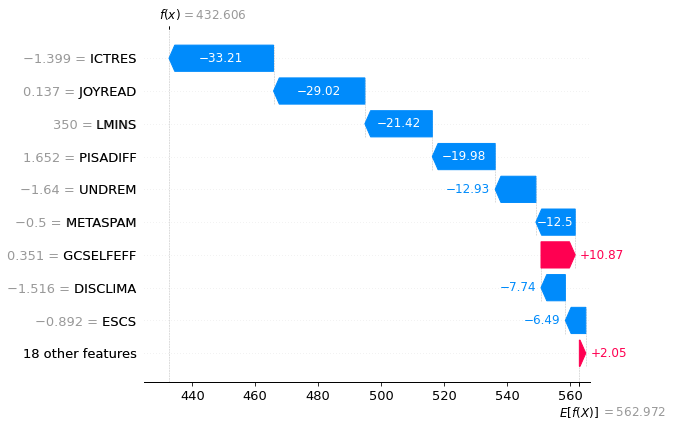

In [68]:
#Explain the model's predictions using SHAP
explainer = shap.Explainer(XGReg2, X_train)
shap_values = explainer(X_train)
shap.plots.waterfall(shap_values[100])

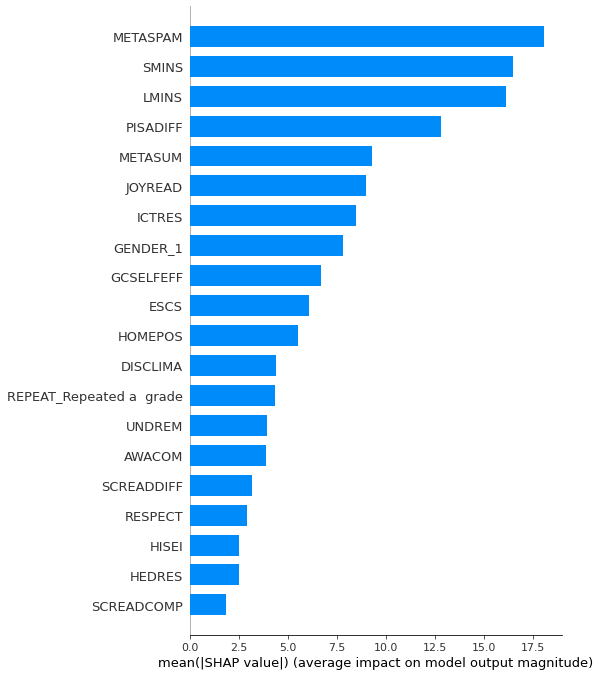

In [70]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

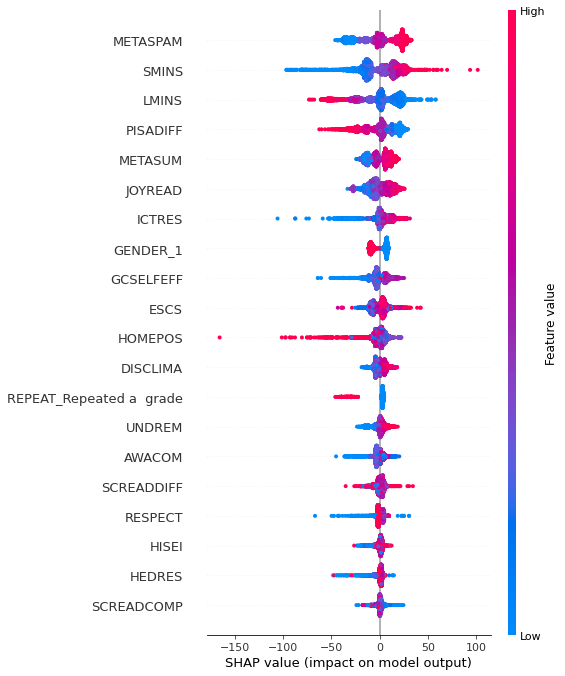

In [71]:
shap.summary_plot(shap_values, X_train)

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


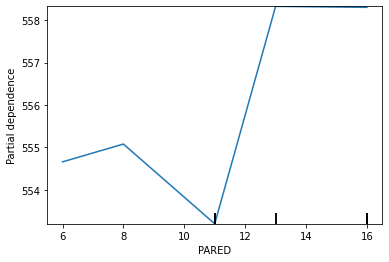

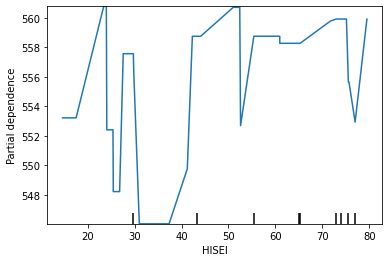

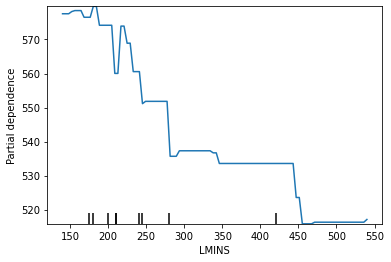

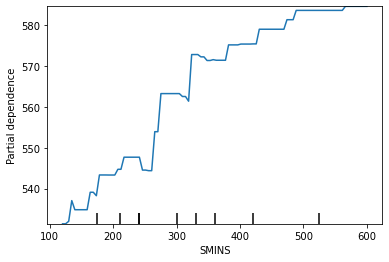

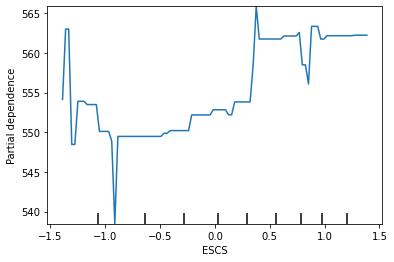

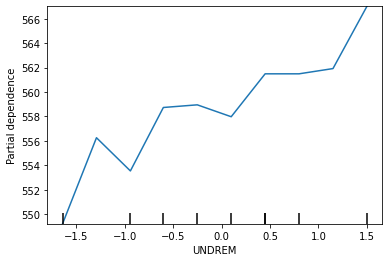

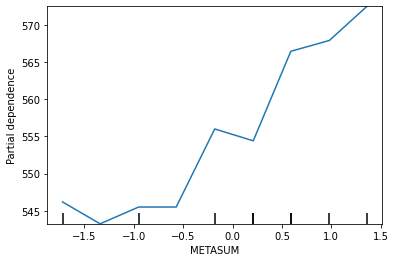

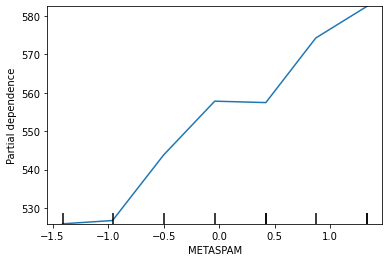

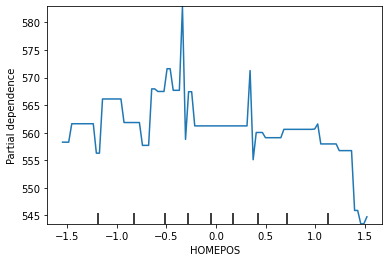

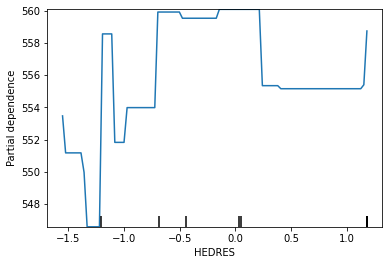

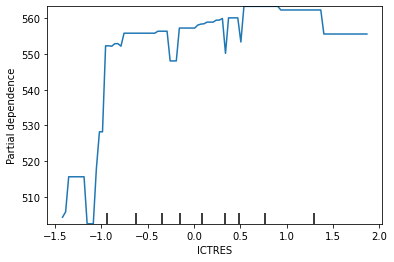

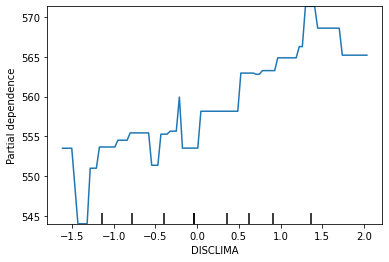

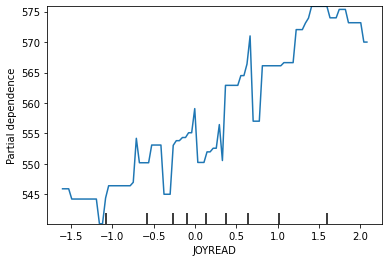

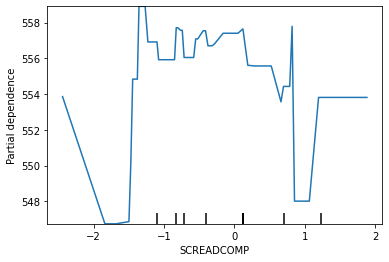

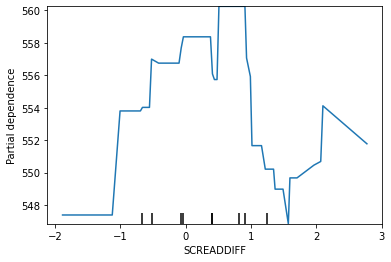

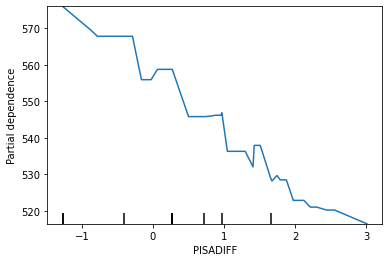

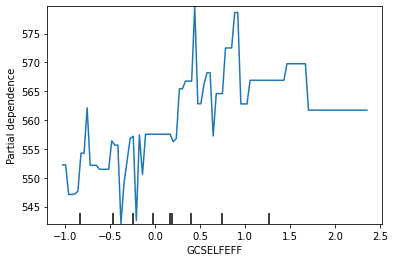

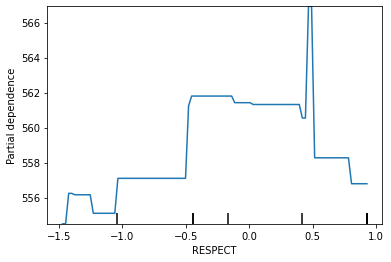

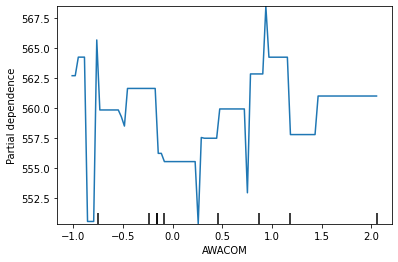

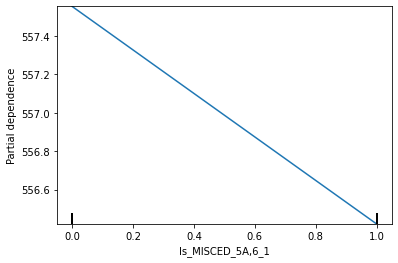

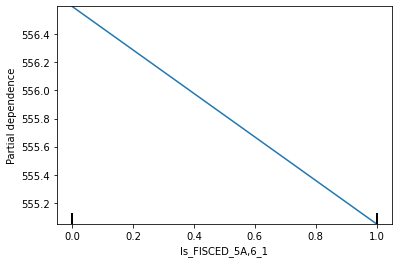

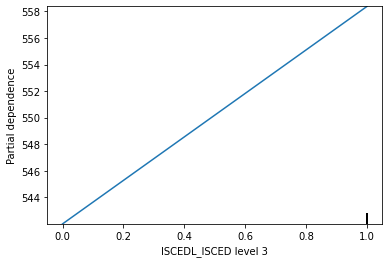

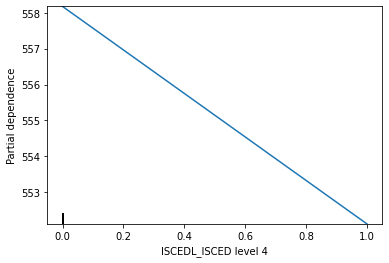

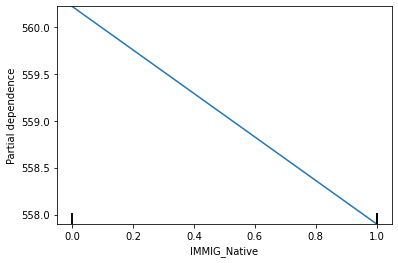

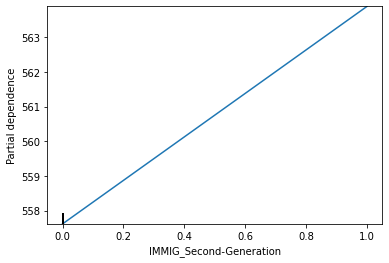

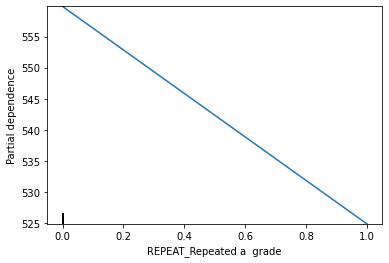

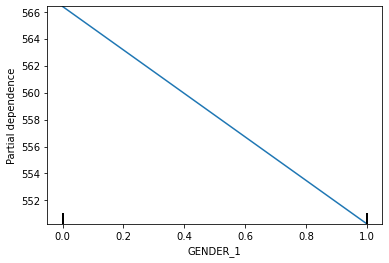

In [72]:
#Generate Partial Dependence Plot
from sklearn.inspection import PartialDependenceDisplay
for cols_name in X_train.columns:
    PartialDependenceDisplay.from_estimator(XGReg2, X_train, [cols_name]);

In [ ]:

#interpretml 
from interpret import show
from interpret.data import Marginal
from interpret.glassbox import ExplainableBoostingRegressor, LinearRegression
from interpret.perf import RegressionPerf

## Explainable Boosting Regressor

In [74]:
#import interpretml 
from interpret import show
from interpret.data import Marginal
from interpret.glassbox import ExplainableBoostingRegressor
from interpret.perf import RegressionPerf

In [75]:
ebm = ExplainableBoostingRegressor(random_state=42, n_jobs=-1, feature_names = X_train.columns)
ebm.fit(X_train, y_train) 

ExplainableBoostingRegressor(feature_names=['PARED', 'HISEI', 'LMINS', 'SMINS',
                                            'ESCS', 'UNDREM', 'METASUM',
                                            'METASPAM', 'HOMEPOS', 'HEDRES',
                                            'ICTRES', 'DISCLIMA', 'JOYREAD',
                                            'SCREADCOMP', 'SCREADDIFF',
                                            'PISADIFF', 'GCSELFEFF', 'RESPECT',
                                            'AWACOM', 'Is_MISCED_5A,6_1',
                                            'Is_FISCED_5A,6_1',
                                            'ISCEDL_ISCED level 3',
                                            'ISCEDL_ISCED level 4',
                                            'IMMIG_Native',
                                            'IMMIG_Second-Generation'...
                                            'continuous', 'continuous',
                                            'continuous', 'continuous',
                                            'continuous', 'continuous',
                                            'continuous', 'continuous',
                                            'continuous', 'continuous',
                                            'continuous', 'continuous',
                                            'continuous', 'continuous',
                                            'continuous', 'categorical',
                                            'categorical', 'categorical',
                                            'categorical', 'categorical',
                                            'categorical', 'categorical',
                                            'categorical', 'interaction',
                                            'interaction', 'interaction', ...],
                             n_jobs=-1)

In [78]:
import warnings
warnings.filterwarnings("ignore")
ebm_global = ebm.explain_global(name='EBM')
show(ebm_global)

<!-- http://127.0.0.1:7557/2169274909648/ -->

In [79]:
ebm_perf = RegressionPerf(ebm.predict).explain_perf(X_test, y_test, name='EBM')
show(ebm_perf)

<!-- http://127.0.0.1:7557/2169275076176/ -->